In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp,contrastive_loss
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\4251183556.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
1024
1024
2000
1024
1024


In [5]:
# initialize model
mlpp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlpp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [6]:
class StaticMemoryBank():

    def __init__(self,batch_size,x,y,dim):
        self.batch_size=batch_size
        self.dim=dim
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=8569, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(x)
        self.x_data=x
        self.y_data=y

    def generate_data(self,x_data,y_data):
        contrasts=np.zeros((self.batch_size,11,self.dim))
        # rare_list=[]
        for step,(x,y) in enumerate(zip(x_data,y_data)):
            if y in [8,10,11,13,14]:
                temp=np.tile(x, 10).reshape((10,2000))
                temp=np.row_stack((temp,x))
                # rare_list.append(step)
                contrasts[step]=temp
            else:
                labels,distances=self.bank.knn_query(x,k=10)
                temp=x_ndarray[labels.tolist()]
                temp=np.row_stack((temp,x))
                contrasts[step]=temp
        
        # return contrasts,rare_list
        return contrasts

In [7]:
def train(instance_loss,cluster_loss,memory_bank,model):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        embedding_data=data.numpy().copy()
        data=data.to('cuda')
        label=label.numpy().copy()
        
        contrast_samples=torch.tensor(memory_bank.generate_data(embedding_data,label),dtype=torch.float32)
        iter_times=10
        for index in range(1,11):
            x_i=contrast_samples[:,0].clone().to('cuda')
            # print(f'sample shape:\n{x_i.shape}')
            
            x_j=contrast_samples[:,index].to('cuda')
            # print(f'data shape:\n{x_j.shape}')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [8]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [9]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    return nmi, ari, f, acc

In [10]:
loss_device=torch.device('cuda')
instance_loss=contrastive_loss.InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=contrastive_loss.ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=StaticMemoryBank(batch_size=args.batch_size,x=x_ndarray,y=y_ndarray,dim=2000)

for epoch in range(args.start_epoch, args.epochs+1):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 1 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    aris.append(ari)
    nmis.append(nmi)
    fs.append(f)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.613417625427246	 loss_cluster: 3.297391414642334
Step [2/8]	 loss_instance: 7.442813873291016	 loss_cluster: 3.296741247177124
Step [4/8]	 loss_instance: 7.132904529571533	 loss_cluster: 3.2931699752807617
Step [6/8]	 loss_instance: 6.979336261749268	 loss_cluster: 3.280600070953369

Epoch [1/200]	 Loss: 10.586215031147002 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5295 ARI = 0.4783 F = 0.6259 ACC = 0.6251



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.7889509201049805	 loss_cluster: 3.2496559619903564
Step [2/8]	 loss_instance: 6.664968967437744	 loss_cluster: 3.1953725814819336
Step [4/8]	 loss_instance: 6.598975658416748	 loss_cluster: 3.101501226425171
Step [6/8]	 loss_instance: 6.568604946136475	 loss_cluster: 2.9980716705322266

Epoch [2/200]	 Loss: 9.825579369068146 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6966 ARI = 0.6936 F = 0.7676 ACC = 0.1199



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.529714584350586	 loss_cluster: 2.893559694290161
Step [2/8]	 loss_instance: 6.4904680252075195	 loss_cluster: 2.7666332721710205
Step [4/8]	 loss_instance: 6.431800365447998	 loss_cluster: 2.583014965057373
Step [6/8]	 loss_instance: 6.402490615844727	 loss_cluster: 2.4410746097564697

Epoch [3/200]	 Loss: 9.179653060436248 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6751 ARI = 0.5144 F = 0.6098 ACC = 0.5675



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.3665666580200195	 loss_cluster: 2.318251132965088
Step [2/8]	 loss_instance: 6.318333148956299	 loss_cluster: 2.2554872035980225
Step [4/8]	 loss_instance: 6.2834858894348145	 loss_cluster: 2.2221598625183105
Step [6/8]	 loss_instance: 6.255882263183594	 loss_cluster: 2.1704647541046143

Epoch [4/200]	 Loss: 8.632506489753723 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6808 ARI = 0.5346 F = 0.6215 ACC = 0.6248



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.230809688568115	 loss_cluster: 2.1473071575164795
Step [2/8]	 loss_instance: 6.22260046005249	 loss_cluster: 2.1258864402770996
Step [4/8]	 loss_instance: 6.219099998474121	 loss_cluster: 2.0989837646484375
Step [6/8]	 loss_instance: 6.208423137664795	 loss_cluster: 2.022711753845215

Epoch [5/200]	 Loss: 8.456669175624848 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6621 ARI = 0.5733 F = 0.6552 ACC = 0.6036



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.164400577545166	 loss_cluster: 2.0099785327911377
Step [2/8]	 loss_instance: 6.15770959854126	 loss_cluster: 1.9659239053726196
Step [4/8]	 loss_instance: 6.166205883026123	 loss_cluster: 1.9874118566513062
Step [6/8]	 loss_instance: 6.1415629386901855	 loss_cluster: 1.9543943405151367

Epoch [6/200]	 Loss: 8.297048640251159 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6626 ARI = 0.4636 F = 0.5698 ACC = 0.5493



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.129255771636963	 loss_cluster: 1.935921311378479
Step [2/8]	 loss_instance: 6.140687942504883	 loss_cluster: 1.929742455482483
Step [4/8]	 loss_instance: 6.113754749298096	 loss_cluster: 1.8994084596633911
Step [6/8]	 loss_instance: 6.123993396759033	 loss_cluster: 1.8883826732635498

Epoch [7/200]	 Loss: 8.198674952983856 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6849 ARI = 0.5010 F = 0.6031 ACC = 0.5410



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.112345218658447	 loss_cluster: 1.901671290397644
Step [2/8]	 loss_instance: 6.105778694152832	 loss_cluster: 1.884162425994873
Step [4/8]	 loss_instance: 6.107747554779053	 loss_cluster: 1.9006900787353516
Step [6/8]	 loss_instance: 6.100037574768066	 loss_cluster: 1.871458888053894

Epoch [8/200]	 Loss: 8.139593440294266 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6736 ARI = 0.4637 F = 0.5702 ACC = 0.5311



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.082013130187988	 loss_cluster: 1.8812434673309326
Step [2/8]	 loss_instance: 6.0736541748046875	 loss_cluster: 1.8499927520751953
Step [4/8]	 loss_instance: 6.0752434730529785	 loss_cluster: 1.8326884508132935
Step [6/8]	 loss_instance: 6.058109760284424	 loss_cluster: 1.8103059530258179

Epoch [9/200]	 Loss: 8.0850909948349 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6866 ARI = 0.4710 F = 0.5810 ACC = 0.5333



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.079629421234131	 loss_cluster: 1.7975332736968994
Step [2/8]	 loss_instance: 6.080868721008301	 loss_cluster: 1.80131196975708
Step [4/8]	 loss_instance: 6.054210186004639	 loss_cluster: 1.7967978715896606
Step [6/8]	 loss_instance: 6.052833080291748	 loss_cluster: 1.7837066650390625

Epoch [10/200]	 Loss: 8.040179795026779 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7150 ARI = 0.4931 F = 0.6003 ACC = 0.5249



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.052309989929199	 loss_cluster: 1.7774091958999634
Step [2/8]	 loss_instance: 6.049397945404053	 loss_cluster: 1.774817705154419
Step [4/8]	 loss_instance: 6.045670509338379	 loss_cluster: 1.754356026649475
Step [6/8]	 loss_instance: 6.049026012420654	 loss_cluster: 1.7610048055648804

Epoch [11/200]	 Loss: 8.00111390352249 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7049 ARI = 0.4855 F = 0.5945 ACC = 0.5404



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.039668560028076	 loss_cluster: 1.7571532726287842
Step [2/8]	 loss_instance: 6.061195373535156	 loss_cluster: 1.7496041059494019
Step [4/8]	 loss_instance: 6.035344123840332	 loss_cluster: 1.7409104108810425
Step [6/8]	 loss_instance: 6.042943477630615	 loss_cluster: 1.7288429737091064

Epoch [12/200]	 Loss: 7.965887492895126 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7001 ARI = 0.4616 F = 0.5742 ACC = 0.5034



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0302910804748535	 loss_cluster: 1.7233775854110718
Step [2/8]	 loss_instance: 6.024873733520508	 loss_cluster: 1.708896517753601
Step [4/8]	 loss_instance: 6.033768177032471	 loss_cluster: 1.7262662649154663
Step [6/8]	 loss_instance: 6.035528182983398	 loss_cluster: 1.722394585609436

Epoch [13/200]	 Loss: 7.946498215198517 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7064 ARI = 0.4838 F = 0.5933 ACC = 0.5642



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.024517059326172	 loss_cluster: 1.6934071779251099
Step [2/8]	 loss_instance: 6.019362449645996	 loss_cluster: 1.6861653327941895
Step [4/8]	 loss_instance: 6.022943019866943	 loss_cluster: 1.7031867504119873
Step [6/8]	 loss_instance: 6.035899639129639	 loss_cluster: 1.7000136375427246

Epoch [14/200]	 Loss: 7.921155643463135 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7322 ARI = 0.4921 F = 0.6024 ACC = 0.5066



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.027531147003174	 loss_cluster: 1.6940739154815674
Step [2/8]	 loss_instance: 6.015276908874512	 loss_cluster: 1.679341435432434
Step [4/8]	 loss_instance: 6.008994102478027	 loss_cluster: 1.6762298345565796
Step [6/8]	 loss_instance: 6.007587909698486	 loss_cluster: 1.6730660200119019

Epoch [15/200]	 Loss: 7.900511837005615 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7307 ARI = 0.4865 F = 0.5977 ACC = 0.5198



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.019410610198975	 loss_cluster: 1.6762499809265137
Step [2/8]	 loss_instance: 6.010862350463867	 loss_cluster: 1.6816394329071045
Step [4/8]	 loss_instance: 6.011483192443848	 loss_cluster: 1.6663955450057983
Step [6/8]	 loss_instance: 6.0138702392578125	 loss_cluster: 1.6804717779159546

Epoch [16/200]	 Loss: 7.8807760894298555 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7357 ARI = 0.5003 F = 0.6092 ACC = 0.5427



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.998918533325195	 loss_cluster: 1.6659069061279297
Step [2/8]	 loss_instance: 6.0133256912231445	 loss_cluster: 1.6916509866714478
Step [4/8]	 loss_instance: 5.9984002113342285	 loss_cluster: 1.648008108139038
Step [6/8]	 loss_instance: 6.002575874328613	 loss_cluster: 1.6476380825042725

Epoch [17/200]	 Loss: 7.862996339797974 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7380 ARI = 0.5098 F = 0.6173 ACC = 0.5492



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.004764080047607	 loss_cluster: 1.660886287689209
Step [2/8]	 loss_instance: 6.022066593170166	 loss_cluster: 1.6659348011016846
Step [4/8]	 loss_instance: 6.006190299987793	 loss_cluster: 1.6628338098526
Step [6/8]	 loss_instance: 5.99570369720459	 loss_cluster: 1.6356364488601685

Epoch [18/200]	 Loss: 7.857188665866852 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7460 ARI = 0.5086 F = 0.6167 ACC = 0.5232



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.996372222900391	 loss_cluster: 1.6502134799957275
Step [2/8]	 loss_instance: 5.99421501159668	 loss_cluster: 1.6579166650772095
Step [4/8]	 loss_instance: 6.00062370300293	 loss_cluster: 1.6484065055847168
Step [6/8]	 loss_instance: 6.002277374267578	 loss_cluster: 1.6586042642593384

Epoch [19/200]	 Loss: 7.839677929878235 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7457 ARI = 0.5075 F = 0.6161 ACC = 0.5217



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.990578651428223	 loss_cluster: 1.6309014558792114
Step [2/8]	 loss_instance: 5.9952826499938965	 loss_cluster: 1.6609272956848145
Step [4/8]	 loss_instance: 6.004802703857422	 loss_cluster: 1.6693331003189087
Step [6/8]	 loss_instance: 5.9807047843933105	 loss_cluster: 1.634412169456482

Epoch [20/200]	 Loss: 7.820193356275558 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7517 ARI = 0.5092 F = 0.6174 ACC = 0.5226



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.981088161468506	 loss_cluster: 1.6339342594146729
Step [2/8]	 loss_instance: 5.989335060119629	 loss_cluster: 1.645895004272461
Step [4/8]	 loss_instance: 5.986861705780029	 loss_cluster: 1.642825961112976
Step [6/8]	 loss_instance: 5.982486248016357	 loss_cluster: 1.6515568494796753

Epoch [21/200]	 Loss: 7.808212637901306 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7456 ARI = 0.5066 F = 0.6155 ACC = 0.5286



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.973844051361084	 loss_cluster: 1.6421669721603394
Step [2/8]	 loss_instance: 5.978549480438232	 loss_cluster: 1.63717782497406
Step [4/8]	 loss_instance: 5.977278709411621	 loss_cluster: 1.6481428146362305
Step [6/8]	 loss_instance: 5.968769073486328	 loss_cluster: 1.614843487739563

Epoch [22/200]	 Loss: 7.789590924978256 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7518 ARI = 0.5097 F = 0.6182 ACC = 0.5137



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.978100299835205	 loss_cluster: 1.6213046312332153
Step [2/8]	 loss_instance: 5.97895622253418	 loss_cluster: 1.6511874198913574
Step [4/8]	 loss_instance: 5.97319221496582	 loss_cluster: 1.628399133682251
Step [6/8]	 loss_instance: 5.966986179351807	 loss_cluster: 1.6228588819503784

Epoch [23/200]	 Loss: 7.7878239274024965 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7554 ARI = 0.5118 F = 0.6208 ACC = 0.5099



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9708428382873535	 loss_cluster: 1.624616265296936
Step [2/8]	 loss_instance: 5.966397762298584	 loss_cluster: 1.623661756515503
Step [4/8]	 loss_instance: 5.973104000091553	 loss_cluster: 1.6275867223739624
Step [6/8]	 loss_instance: 5.959714889526367	 loss_cluster: 1.631282091140747

Epoch [24/200]	 Loss: 7.782645577192307 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7548 ARI = 0.5122 F = 0.6207 ACC = 0.5146



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.967620849609375	 loss_cluster: 1.6262481212615967
Step [2/8]	 loss_instance: 5.9598870277404785	 loss_cluster: 1.6381250619888306
Step [4/8]	 loss_instance: 5.962067127227783	 loss_cluster: 1.6327685117721558
Step [6/8]	 loss_instance: 5.966175079345703	 loss_cluster: 1.6256805658340454

Epoch [25/200]	 Loss: 7.766873061656952 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7560 ARI = 0.5105 F = 0.6194 ACC = 0.5135



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.947949409484863	 loss_cluster: 1.604712724685669
Step [2/8]	 loss_instance: 5.974722385406494	 loss_cluster: 1.630315899848938
Step [4/8]	 loss_instance: 5.962348937988281	 loss_cluster: 1.6364129781723022
Step [6/8]	 loss_instance: 5.972222805023193	 loss_cluster: 1.6389905214309692

Epoch [26/200]	 Loss: 7.779542762041092 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7438 ARI = 0.4952 F = 0.6066 ACC = 0.5237



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.969733715057373	 loss_cluster: 1.6351667642593384
Step [2/8]	 loss_instance: 5.970907211303711	 loss_cluster: 1.6438488960266113
Step [4/8]	 loss_instance: 5.982607364654541	 loss_cluster: 1.643596887588501
Step [6/8]	 loss_instance: 5.970125198364258	 loss_cluster: 1.623873233795166

Epoch [27/200]	 Loss: 7.801451694965363 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7380 ARI = 0.4960 F = 0.6057 ACC = 0.5396



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.96747350692749	 loss_cluster: 1.6269537210464478
Step [2/8]	 loss_instance: 5.967901706695557	 loss_cluster: 1.6381741762161255
Step [4/8]	 loss_instance: 5.970845699310303	 loss_cluster: 1.6297283172607422
Step [6/8]	 loss_instance: 5.961855888366699	 loss_cluster: 1.618349552154541

Epoch [28/200]	 Loss: 7.780453312397003 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7589 ARI = 0.5148 F = 0.6232 ACC = 0.5223



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.963961601257324	 loss_cluster: 1.6203622817993164
Step [2/8]	 loss_instance: 5.952497482299805	 loss_cluster: 1.6126075983047485
Step [4/8]	 loss_instance: 5.961794853210449	 loss_cluster: 1.6182574033737183
Step [6/8]	 loss_instance: 5.95626974105835	 loss_cluster: 1.621623158454895

Epoch [29/200]	 Loss: 7.748421317338943 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7547 ARI = 0.5092 F = 0.6181 ACC = 0.5144



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.954056739807129	 loss_cluster: 1.6185007095336914
Step [2/8]	 loss_instance: 5.950417518615723	 loss_cluster: 1.6134898662567139
Step [4/8]	 loss_instance: 5.951910495758057	 loss_cluster: 1.6227550506591797
Step [6/8]	 loss_instance: 5.940213680267334	 loss_cluster: 1.628001093864441

Epoch [30/200]	 Loss: 7.737810438871383 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7516 ARI = 0.5027 F = 0.6125 ACC = 0.5022



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.943821430206299	 loss_cluster: 1.6010661125183105
Step [2/8]	 loss_instance: 5.94448709487915	 loss_cluster: 1.623294711112976
Step [4/8]	 loss_instance: 5.943944931030273	 loss_cluster: 1.623631477355957
Step [6/8]	 loss_instance: 5.945407867431641	 loss_cluster: 1.6216026544570923

Epoch [31/200]	 Loss: 7.73609710931778 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7402 ARI = 0.4925 F = 0.6033 ACC = 0.5103



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.936514854431152	 loss_cluster: 1.6133919954299927
Step [2/8]	 loss_instance: 5.936891078948975	 loss_cluster: 1.6116249561309814
Step [4/8]	 loss_instance: 5.944797039031982	 loss_cluster: 1.6153000593185425
Step [6/8]	 loss_instance: 5.934638023376465	 loss_cluster: 1.619011402130127

Epoch [32/200]	 Loss: 7.729632019996643 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7506 ARI = 0.5026 F = 0.6122 ACC = 0.5118



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9347381591796875	 loss_cluster: 1.6182194948196411
Step [2/8]	 loss_instance: 5.9387407302856445	 loss_cluster: 1.6182899475097656
Step [4/8]	 loss_instance: 5.943796634674072	 loss_cluster: 1.6261218786239624
Step [6/8]	 loss_instance: 5.940210819244385	 loss_cluster: 1.6108673810958862

Epoch [33/200]	 Loss: 7.7249261915683745 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7474 ARI = 0.4965 F = 0.6070 ACC = 0.5033



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.935288906097412	 loss_cluster: 1.6123172044754028
Step [2/8]	 loss_instance: 5.9339070320129395	 loss_cluster: 1.6099086999893188
Step [4/8]	 loss_instance: 5.934094429016113	 loss_cluster: 1.6137882471084595
Step [6/8]	 loss_instance: 5.929108142852783	 loss_cluster: 1.605025053024292

Epoch [34/200]	 Loss: 7.716128867864609 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7436 ARI = 0.4908 F = 0.6022 ACC = 0.4991



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.924705982208252	 loss_cluster: 1.5957223176956177
Step [2/8]	 loss_instance: 5.928802013397217	 loss_cluster: 1.6114896535873413
Step [4/8]	 loss_instance: 5.937921524047852	 loss_cluster: 1.6265876293182373
Step [6/8]	 loss_instance: 5.94628381729126	 loss_cluster: 1.6157366037368774

Epoch [35/200]	 Loss: 7.720780295133591 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7393 ARI = 0.4828 F = 0.5953 ACC = 0.5000



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.928550720214844	 loss_cluster: 1.6038731336593628
Step [2/8]	 loss_instance: 5.942874908447266	 loss_cluster: 1.6237823963165283
Step [4/8]	 loss_instance: 5.9235663414001465	 loss_cluster: 1.6086403131484985
Step [6/8]	 loss_instance: 5.9320068359375	 loss_cluster: 1.6162101030349731

Epoch [36/200]	 Loss: 7.720966929197312 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7354 ARI = 0.4832 F = 0.5955 ACC = 0.5139



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.929221153259277	 loss_cluster: 1.6173046827316284
Step [2/8]	 loss_instance: 5.934067726135254	 loss_cluster: 1.6171221733093262
Step [4/8]	 loss_instance: 5.931560516357422	 loss_cluster: 1.6074730157852173
Step [6/8]	 loss_instance: 5.932642936706543	 loss_cluster: 1.6314475536346436

Epoch [37/200]	 Loss: 7.718560332059861 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7345 ARI = 0.4798 F = 0.5926 ACC = 0.4958



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.938120365142822	 loss_cluster: 1.6212178468704224
Step [2/8]	 loss_instance: 5.92725944519043	 loss_cluster: 1.6272058486938477
Step [4/8]	 loss_instance: 5.928626537322998	 loss_cluster: 1.601607084274292
Step [6/8]	 loss_instance: 5.925388813018799	 loss_cluster: 1.6001919507980347

Epoch [38/200]	 Loss: 7.7204481899738315 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7408 ARI = 0.4896 F = 0.6010 ACC = 0.5111



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.924370288848877	 loss_cluster: 1.6173334121704102
Step [2/8]	 loss_instance: 5.9258222579956055	 loss_cluster: 1.604759693145752
Step [4/8]	 loss_instance: 5.931567668914795	 loss_cluster: 1.6061040163040161
Step [6/8]	 loss_instance: 5.921802997589111	 loss_cluster: 1.6061557531356812

Epoch [39/200]	 Loss: 7.708480393886566 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7406 ARI = 0.4855 F = 0.5971 ACC = 0.4952



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.928120136260986	 loss_cluster: 1.6189956665039062
Step [2/8]	 loss_instance: 5.916477203369141	 loss_cluster: 1.5986377000808716
Step [4/8]	 loss_instance: 5.914486408233643	 loss_cluster: 1.5987985134124756
Step [6/8]	 loss_instance: 5.920853614807129	 loss_cluster: 1.6115132570266724

Epoch [40/200]	 Loss: 7.702122688293457 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7332 ARI = 0.4758 F = 0.5886 ACC = 0.5065



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.917993068695068	 loss_cluster: 1.5968948602676392
Step [2/8]	 loss_instance: 5.930634021759033	 loss_cluster: 1.6175382137298584
Step [4/8]	 loss_instance: 5.917301654815674	 loss_cluster: 1.592805027961731
Step [6/8]	 loss_instance: 5.91695499420166	 loss_cluster: 1.60311758518219

Epoch [41/200]	 Loss: 7.691681265830994 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7298 ARI = 0.4736 F = 0.5869 ACC = 0.4924



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.91533088684082	 loss_cluster: 1.6110625267028809
Step [2/8]	 loss_instance: 5.915782928466797	 loss_cluster: 1.6086844205856323
Step [4/8]	 loss_instance: 5.929669380187988	 loss_cluster: 1.622045874595642
Step [6/8]	 loss_instance: 5.908466339111328	 loss_cluster: 1.5970834493637085

Epoch [42/200]	 Loss: 7.694789725542068 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7359 ARI = 0.4773 F = 0.5904 ACC = 0.4935



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.91840934753418	 loss_cluster: 1.5993402004241943
Step [2/8]	 loss_instance: 5.9170660972595215	 loss_cluster: 1.6055306196212769
Step [4/8]	 loss_instance: 5.928208827972412	 loss_cluster: 1.6081517934799194
Step [6/8]	 loss_instance: 5.925833225250244	 loss_cluster: 1.611618161201477

Epoch [43/200]	 Loss: 7.70214461684227 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7216 ARI = 0.4662 F = 0.5805 ACC = 0.4945



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.910475254058838	 loss_cluster: 1.600257396697998
Step [2/8]	 loss_instance: 5.923920154571533	 loss_cluster: 1.5965508222579956
Step [4/8]	 loss_instance: 5.916435718536377	 loss_cluster: 1.5967170000076294
Step [6/8]	 loss_instance: 5.915851593017578	 loss_cluster: 1.6045045852661133

Epoch [44/200]	 Loss: 7.6830188691616055 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7311 ARI = 0.4709 F = 0.5845 ACC = 0.4943



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914209365844727	 loss_cluster: 1.5967880487442017
Step [2/8]	 loss_instance: 5.921936988830566	 loss_cluster: 1.6072461605072021
Step [4/8]	 loss_instance: 5.909712791442871	 loss_cluster: 1.6000727415084839
Step [6/8]	 loss_instance: 5.922438144683838	 loss_cluster: 1.60964834690094

Epoch [45/200]	 Loss: 7.6932903051376345 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7289 ARI = 0.4674 F = 0.5813 ACC = 0.5133



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.91270112991333	 loss_cluster: 1.587608814239502
Step [2/8]	 loss_instance: 5.917904376983643	 loss_cluster: 1.61320161819458
Step [4/8]	 loss_instance: 5.913775444030762	 loss_cluster: 1.6117594242095947
Step [6/8]	 loss_instance: 5.91845703125	 loss_cluster: 1.5990824699401855

Epoch [46/200]	 Loss: 7.6850253462791445 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7226 ARI = 0.4546 F = 0.5703 ACC = 0.4991



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9206366539001465	 loss_cluster: 1.5946415662765503
Step [2/8]	 loss_instance: 5.905745506286621	 loss_cluster: 1.5949381589889526
Step [4/8]	 loss_instance: 5.918684482574463	 loss_cluster: 1.602713942527771
Step [6/8]	 loss_instance: 5.912456035614014	 loss_cluster: 1.6097224950790405

Epoch [47/200]	 Loss: 7.68322189450264 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7285 ARI = 0.4630 F = 0.5773 ACC = 0.4907



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9156107902526855	 loss_cluster: 1.603192687034607
Step [2/8]	 loss_instance: 5.908998012542725	 loss_cluster: 1.5981040000915527
Step [4/8]	 loss_instance: 5.911200523376465	 loss_cluster: 1.5992289781570435
Step [6/8]	 loss_instance: 5.9190802574157715	 loss_cluster: 1.6104159355163574

Epoch [48/200]	 Loss: 7.688734072446823 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7254 ARI = 0.4631 F = 0.5779 ACC = 0.4926



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.917275428771973	 loss_cluster: 1.5969470739364624
Step [2/8]	 loss_instance: 5.908420562744141	 loss_cluster: 1.5925191640853882
Step [4/8]	 loss_instance: 5.921899795532227	 loss_cluster: 1.6168936491012573
Step [6/8]	 loss_instance: 5.911096572875977	 loss_cluster: 1.5948902368545532

Epoch [49/200]	 Loss: 7.679540264606476 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7254 ARI = 0.4628 F = 0.5774 ACC = 0.4860



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.905904769897461	 loss_cluster: 1.5978144407272339
Step [2/8]	 loss_instance: 5.9111833572387695	 loss_cluster: 1.6032366752624512
Step [4/8]	 loss_instance: 5.9093146324157715	 loss_cluster: 1.593951940536499
Step [6/8]	 loss_instance: 5.916392803192139	 loss_cluster: 1.603955864906311

Epoch [50/200]	 Loss: 7.674454343318939 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7242 ARI = 0.4595 F = 0.5745 ACC = 0.4906



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914656162261963	 loss_cluster: 1.59454345703125
Step [2/8]	 loss_instance: 5.910204887390137	 loss_cluster: 1.6077090501785278
Step [4/8]	 loss_instance: 5.911020278930664	 loss_cluster: 1.598753571510315
Step [6/8]	 loss_instance: 5.898608207702637	 loss_cluster: 1.5805473327636719

Epoch [51/200]	 Loss: 7.683296775817871 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7338 ARI = 0.4757 F = 0.5884 ACC = 0.5027



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.915092945098877	 loss_cluster: 1.5927612781524658
Step [2/8]	 loss_instance: 5.897637844085693	 loss_cluster: 1.581700086593628
Step [4/8]	 loss_instance: 5.908507823944092	 loss_cluster: 1.6013436317443848
Step [6/8]	 loss_instance: 5.912203788757324	 loss_cluster: 1.6000062227249146

Epoch [52/200]	 Loss: 7.675682657957077 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7222 ARI = 0.4540 F = 0.5698 ACC = 0.4867



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.892173767089844	 loss_cluster: 1.5961905717849731
Step [2/8]	 loss_instance: 5.901412487030029	 loss_cluster: 1.5863524675369263
Step [4/8]	 loss_instance: 5.908614635467529	 loss_cluster: 1.600832462310791
Step [6/8]	 loss_instance: 5.902537822723389	 loss_cluster: 1.593814730644226

Epoch [53/200]	 Loss: 7.6697343528270725 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7214 ARI = 0.4536 F = 0.5695 ACC = 0.4822



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903093338012695	 loss_cluster: 1.6036731004714966
Step [2/8]	 loss_instance: 5.907548427581787	 loss_cluster: 1.5930382013320923
Step [4/8]	 loss_instance: 5.910881996154785	 loss_cluster: 1.589931845664978
Step [6/8]	 loss_instance: 5.903225421905518	 loss_cluster: 1.5948113203048706

Epoch [54/200]	 Loss: 7.668472003936768 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7213 ARI = 0.4616 F = 0.5764 ACC = 0.4868



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.90796422958374	 loss_cluster: 1.5894044637680054
Step [2/8]	 loss_instance: 5.893928527832031	 loss_cluster: 1.5799795389175415
Step [4/8]	 loss_instance: 5.9028825759887695	 loss_cluster: 1.5991696119308472
Step [6/8]	 loss_instance: 5.89958381652832	 loss_cluster: 1.5929843187332153

Epoch [55/200]	 Loss: 7.670516031980514 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7317 ARI = 0.4697 F = 0.5836 ACC = 0.5048



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.90519380569458	 loss_cluster: 1.5910414457321167
Step [2/8]	 loss_instance: 5.910544395446777	 loss_cluster: 1.5866584777832031
Step [4/8]	 loss_instance: 5.905892848968506	 loss_cluster: 1.5907158851623535
Step [6/8]	 loss_instance: 5.915117263793945	 loss_cluster: 1.6073170900344849

Epoch [56/200]	 Loss: 7.664680856466293 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7192 ARI = 0.4440 F = 0.5608 ACC = 0.4757



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.902453422546387	 loss_cluster: 1.6013129949569702
Step [2/8]	 loss_instance: 5.909305572509766	 loss_cluster: 1.5867528915405273
Step [4/8]	 loss_instance: 5.90213680267334	 loss_cluster: 1.5868744850158691
Step [6/8]	 loss_instance: 5.906164169311523	 loss_cluster: 1.5860129594802856

Epoch [57/200]	 Loss: 7.66827791929245 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7261 ARI = 0.4604 F = 0.5754 ACC = 0.5083



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904954433441162	 loss_cluster: 1.5924263000488281
Step [2/8]	 loss_instance: 5.901233196258545	 loss_cluster: 1.5890847444534302
Step [4/8]	 loss_instance: 5.908820152282715	 loss_cluster: 1.5956839323043823
Step [6/8]	 loss_instance: 5.9096527099609375	 loss_cluster: 1.586854338645935

Epoch [58/200]	 Loss: 7.665014749765396 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7309 ARI = 0.4666 F = 0.5804 ACC = 0.4946



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901255130767822	 loss_cluster: 1.585949182510376
Step [2/8]	 loss_instance: 5.898857116699219	 loss_cluster: 1.5834676027297974
Step [4/8]	 loss_instance: 5.906816482543945	 loss_cluster: 1.5967764854431152
Step [6/8]	 loss_instance: 5.893641948699951	 loss_cluster: 1.582834005355835

Epoch [59/200]	 Loss: 7.652147245407105 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7216 ARI = 0.4502 F = 0.5665 ACC = 0.4944



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.895813941955566	 loss_cluster: 1.587357521057129
Step [2/8]	 loss_instance: 5.893128395080566	 loss_cluster: 1.5800389051437378
Step [4/8]	 loss_instance: 5.901253700256348	 loss_cluster: 1.5959347486495972
Step [6/8]	 loss_instance: 5.89586877822876	 loss_cluster: 1.5851390361785889

Epoch [60/200]	 Loss: 7.657263833284378 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7229 ARI = 0.4553 F = 0.5708 ACC = 0.4957



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9021100997924805	 loss_cluster: 1.5956460237503052
Step [2/8]	 loss_instance: 5.892955780029297	 loss_cluster: 1.5927900075912476
Step [4/8]	 loss_instance: 5.901030540466309	 loss_cluster: 1.5934112071990967
Step [6/8]	 loss_instance: 5.905935764312744	 loss_cluster: 1.5992801189422607

Epoch [61/200]	 Loss: 7.66395725607872 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7256 ARI = 0.4591 F = 0.5739 ACC = 0.5088



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.898975849151611	 loss_cluster: 1.5967055559158325
Step [2/8]	 loss_instance: 5.906558990478516	 loss_cluster: 1.6002267599105835
Step [4/8]	 loss_instance: 5.910411357879639	 loss_cluster: 1.6085163354873657
Step [6/8]	 loss_instance: 5.906735897064209	 loss_cluster: 1.5925480127334595

Epoch [62/200]	 Loss: 7.662250941991806 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7165 ARI = 0.4438 F = 0.5606 ACC = 0.4841



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904415607452393	 loss_cluster: 1.602698564529419
Step [2/8]	 loss_instance: 5.8925395011901855	 loss_cluster: 1.581464409828186
Step [4/8]	 loss_instance: 5.890440940856934	 loss_cluster: 1.5768873691558838
Step [6/8]	 loss_instance: 5.901970863342285	 loss_cluster: 1.584087610244751

Epoch [63/200]	 Loss: 7.653380972146988 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7101 ARI = 0.4331 F = 0.5505 ACC = 0.4877



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9004740715026855	 loss_cluster: 1.5949116945266724
Step [2/8]	 loss_instance: 5.897067546844482	 loss_cluster: 1.5908973217010498
Step [4/8]	 loss_instance: 5.902698993682861	 loss_cluster: 1.5864847898483276
Step [6/8]	 loss_instance: 5.899441719055176	 loss_cluster: 1.5856058597564697

Epoch [64/200]	 Loss: 7.65592480301857 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7199 ARI = 0.4514 F = 0.5674 ACC = 0.4863



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896895408630371	 loss_cluster: 1.585276484489441
Step [2/8]	 loss_instance: 5.9090189933776855	 loss_cluster: 1.5971661806106567
Step [4/8]	 loss_instance: 5.8947906494140625	 loss_cluster: 1.583717942237854
Step [6/8]	 loss_instance: 5.891262531280518	 loss_cluster: 1.5820657014846802

Epoch [65/200]	 Loss: 7.648279058933258 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7224 ARI = 0.4531 F = 0.5692 ACC = 0.4896



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.897230625152588	 loss_cluster: 1.587005376815796
Step [2/8]	 loss_instance: 5.899357795715332	 loss_cluster: 1.583071231842041
Step [4/8]	 loss_instance: 5.898151874542236	 loss_cluster: 1.594530463218689
Step [6/8]	 loss_instance: 5.893852710723877	 loss_cluster: 1.5886121988296509

Epoch [66/200]	 Loss: 7.653439146280289 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7183 ARI = 0.4453 F = 0.5622 ACC = 0.4998



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896244049072266	 loss_cluster: 1.579673409461975
Step [2/8]	 loss_instance: 5.899825096130371	 loss_cluster: 1.5938913822174072
Step [4/8]	 loss_instance: 5.90458345413208	 loss_cluster: 1.5984303951263428
Step [6/8]	 loss_instance: 5.891948699951172	 loss_cluster: 1.580782175064087

Epoch [67/200]	 Loss: 7.658162611722946 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7236 ARI = 0.4544 F = 0.5697 ACC = 0.5009



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.90505313873291	 loss_cluster: 1.5938856601715088
Step [2/8]	 loss_instance: 5.885436534881592	 loss_cluster: 1.5792262554168701
Step [4/8]	 loss_instance: 5.895627498626709	 loss_cluster: 1.5793942213058472
Step [6/8]	 loss_instance: 5.894235134124756	 loss_cluster: 1.5807114839553833

Epoch [68/200]	 Loss: 7.644969177246094 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7194 ARI = 0.4399 F = 0.5573 ACC = 0.4807



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.889688968658447	 loss_cluster: 1.582194447517395
Step [2/8]	 loss_instance: 5.88468074798584	 loss_cluster: 1.5705682039260864
Step [4/8]	 loss_instance: 5.889310359954834	 loss_cluster: 1.5734537839889526
Step [6/8]	 loss_instance: 5.8953022956848145	 loss_cluster: 1.5800607204437256

Epoch [69/200]	 Loss: 7.639590305089951 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7180 ARI = 0.4342 F = 0.5522 ACC = 0.4806



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.889013767242432	 loss_cluster: 1.5791311264038086
Step [2/8]	 loss_instance: 5.895881652832031	 loss_cluster: 1.586004614830017
Step [4/8]	 loss_instance: 5.89012336730957	 loss_cluster: 1.5719586610794067
Step [6/8]	 loss_instance: 5.892104625701904	 loss_cluster: 1.5811949968338013

Epoch [70/200]	 Loss: 7.63869194984436 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7195 ARI = 0.4411 F = 0.5584 ACC = 0.4845



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891733646392822	 loss_cluster: 1.5802257061004639
Step [2/8]	 loss_instance: 5.888671875	 loss_cluster: 1.5821599960327148
Step [4/8]	 loss_instance: 5.890867233276367	 loss_cluster: 1.5794492959976196
Step [6/8]	 loss_instance: 5.890699863433838	 loss_cluster: 1.5755869150161743

Epoch [71/200]	 Loss: 7.634170430898666 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7224 ARI = 0.4457 F = 0.5622 ACC = 0.4849



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.894276142120361	 loss_cluster: 1.5825520753860474
Step [2/8]	 loss_instance: 5.887477397918701	 loss_cluster: 1.5826441049575806
Step [4/8]	 loss_instance: 5.881567001342773	 loss_cluster: 1.5675724744796753
Step [6/8]	 loss_instance: 5.886160373687744	 loss_cluster: 1.5761090517044067

Epoch [72/200]	 Loss: 7.640398454666138 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7176 ARI = 0.4471 F = 0.5637 ACC = 0.4983



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.889770984649658	 loss_cluster: 1.5783442258834839
Step [2/8]	 loss_instance: 5.881931304931641	 loss_cluster: 1.5745875835418701
Step [4/8]	 loss_instance: 5.898493766784668	 loss_cluster: 1.5866994857788086
Step [6/8]	 loss_instance: 5.8860087394714355	 loss_cluster: 1.5889508724212646

Epoch [73/200]	 Loss: 7.65316601395607 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7170 ARI = 0.4436 F = 0.5609 ACC = 0.4835



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.900321006774902	 loss_cluster: 1.5944346189498901
Step [2/8]	 loss_instance: 5.900030136108398	 loss_cluster: 1.5893442630767822
Step [4/8]	 loss_instance: 5.894881248474121	 loss_cluster: 1.5915119647979736
Step [6/8]	 loss_instance: 5.8893632888793945	 loss_cluster: 1.5835741758346558

Epoch [74/200]	 Loss: 7.642689847946167 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7219 ARI = 0.4476 F = 0.5645 ACC = 0.4865



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.895999908447266	 loss_cluster: 1.5861104726791382
Step [2/8]	 loss_instance: 5.8890814781188965	 loss_cluster: 1.5704156160354614
Step [4/8]	 loss_instance: 5.8774895668029785	 loss_cluster: 1.573297381401062
Step [6/8]	 loss_instance: 5.890696048736572	 loss_cluster: 1.5762853622436523

Epoch [75/200]	 Loss: 7.63994607925415 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7166 ARI = 0.4315 F = 0.5496 ACC = 0.4750



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.877326965332031	 loss_cluster: 1.5739325284957886
Step [2/8]	 loss_instance: 5.889859676361084	 loss_cluster: 1.5888291597366333
Step [4/8]	 loss_instance: 5.893176555633545	 loss_cluster: 1.5793508291244507
Step [6/8]	 loss_instance: 5.882893085479736	 loss_cluster: 1.5774182081222534

Epoch [76/200]	 Loss: 7.641680586338043 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7058 ARI = 0.4334 F = 0.5514 ACC = 0.4996



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.89592981338501	 loss_cluster: 1.5835973024368286
Step [2/8]	 loss_instance: 5.893789768218994	 loss_cluster: 1.5844371318817139
Step [4/8]	 loss_instance: 5.892834663391113	 loss_cluster: 1.5861378908157349
Step [6/8]	 loss_instance: 5.8872199058532715	 loss_cluster: 1.5755523443222046

Epoch [77/200]	 Loss: 7.639155530929566 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7183 ARI = 0.4399 F = 0.5572 ACC = 0.4861



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.880800247192383	 loss_cluster: 1.5660488605499268
Step [2/8]	 loss_instance: 5.878157615661621	 loss_cluster: 1.5739601850509644
Step [4/8]	 loss_instance: 5.897021770477295	 loss_cluster: 1.5831645727157593
Step [6/8]	 loss_instance: 5.888235092163086	 loss_cluster: 1.5936639308929443

Epoch [78/200]	 Loss: 7.636884319782257 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6985 ARI = 0.4206 F = 0.5398 ACC = 0.4832



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9083781242370605	 loss_cluster: 1.5881632566452026
Step [2/8]	 loss_instance: 5.900210857391357	 loss_cluster: 1.6018850803375244
Step [4/8]	 loss_instance: 5.889939308166504	 loss_cluster: 1.5822231769561768
Step [6/8]	 loss_instance: 5.883335113525391	 loss_cluster: 1.5786733627319336

Epoch [79/200]	 Loss: 7.650582438707351 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7023 ARI = 0.4186 F = 0.5378 ACC = 0.4722



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890091896057129	 loss_cluster: 1.570464015007019
Step [2/8]	 loss_instance: 5.882809162139893	 loss_cluster: 1.5772194862365723
Step [4/8]	 loss_instance: 5.888885021209717	 loss_cluster: 1.5849050283432007
Step [6/8]	 loss_instance: 5.885301113128662	 loss_cluster: 1.5794041156768799

Epoch [80/200]	 Loss: 7.6336450457572935 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7165 ARI = 0.4327 F = 0.5512 ACC = 0.4794



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8899827003479	 loss_cluster: 1.5870896577835083
Step [2/8]	 loss_instance: 5.88100528717041	 loss_cluster: 1.5799615383148193
Step [4/8]	 loss_instance: 5.881128787994385	 loss_cluster: 1.5731481313705444
Step [6/8]	 loss_instance: 5.882047176361084	 loss_cluster: 1.573398232460022

Epoch [81/200]	 Loss: 7.631947338581085 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7026 ARI = 0.4173 F = 0.5367 ACC = 0.4706



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.871210098266602	 loss_cluster: 1.5688623189926147
Step [2/8]	 loss_instance: 5.886021137237549	 loss_cluster: 1.5821934938430786
Step [4/8]	 loss_instance: 5.8787102699279785	 loss_cluster: 1.5718109607696533
Step [6/8]	 loss_instance: 5.890833377838135	 loss_cluster: 1.5779650211334229

Epoch [82/200]	 Loss: 7.62542177438736 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6914 ARI = 0.3943 F = 0.5159 ACC = 0.4650



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.886491298675537	 loss_cluster: 1.5733393430709839
Step [2/8]	 loss_instance: 5.88392448425293	 loss_cluster: 1.5799338817596436
Step [4/8]	 loss_instance: 5.8870038986206055	 loss_cluster: 1.5749002695083618
Step [6/8]	 loss_instance: 5.885484218597412	 loss_cluster: 1.57341730594635

Epoch [83/200]	 Loss: 7.63619686961174 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7024 ARI = 0.4219 F = 0.5414 ACC = 0.4805



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.88217306137085	 loss_cluster: 1.582480788230896
Step [2/8]	 loss_instance: 5.878239631652832	 loss_cluster: 1.5764646530151367
Step [4/8]	 loss_instance: 5.879632949829102	 loss_cluster: 1.5768359899520874
Step [6/8]	 loss_instance: 5.880354881286621	 loss_cluster: 1.5841211080551147

Epoch [84/200]	 Loss: 7.639516806602478 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6950 ARI = 0.4113 F = 0.5305 ACC = 0.4843



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.893856525421143	 loss_cluster: 1.5808706283569336
Step [2/8]	 loss_instance: 5.882987976074219	 loss_cluster: 1.575892686843872
Step [4/8]	 loss_instance: 5.893595218658447	 loss_cluster: 1.5863772630691528
Step [6/8]	 loss_instance: 5.886953353881836	 loss_cluster: 1.5789231061935425

Epoch [85/200]	 Loss: 7.643766075372696 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6951 ARI = 0.4119 F = 0.5313 ACC = 0.4866



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.888579368591309	 loss_cluster: 1.5724470615386963
Step [2/8]	 loss_instance: 5.8831658363342285	 loss_cluster: 1.5847073793411255
Step [4/8]	 loss_instance: 5.876272201538086	 loss_cluster: 1.571731448173523
Step [6/8]	 loss_instance: 5.887264728546143	 loss_cluster: 1.579944133758545

Epoch [86/200]	 Loss: 7.629339510202408 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6891 ARI = 0.4005 F = 0.5214 ACC = 0.4801



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.879071235656738	 loss_cluster: 1.5749679803848267
Step [2/8]	 loss_instance: 5.88314151763916	 loss_cluster: 1.570356845855713
Step [4/8]	 loss_instance: 5.8810577392578125	 loss_cluster: 1.573433756828308
Step [6/8]	 loss_instance: 5.879459381103516	 loss_cluster: 1.5664074420928955

Epoch [87/200]	 Loss: 7.624651104211807 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6945 ARI = 0.4023 F = 0.5227 ACC = 0.4636



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.88004732131958	 loss_cluster: 1.5746225118637085
Step [2/8]	 loss_instance: 5.884805202484131	 loss_cluster: 1.5749077796936035
Step [4/8]	 loss_instance: 5.875973224639893	 loss_cluster: 1.5816148519515991
Step [6/8]	 loss_instance: 5.879614353179932	 loss_cluster: 1.5757439136505127

Epoch [88/200]	 Loss: 7.627418506145477 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6974 ARI = 0.4057 F = 0.5258 ACC = 0.4702



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.880041599273682	 loss_cluster: 1.5761806964874268
Step [2/8]	 loss_instance: 5.882122993469238	 loss_cluster: 1.5786998271942139
Step [4/8]	 loss_instance: 5.885696887969971	 loss_cluster: 1.5823391675949097
Step [6/8]	 loss_instance: 5.881312370300293	 loss_cluster: 1.5787287950515747

Epoch [89/200]	 Loss: 7.632857304811478 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6990 ARI = 0.4119 F = 0.5317 ACC = 0.4937



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884208679199219	 loss_cluster: 1.5744097232818604
Step [2/8]	 loss_instance: 5.878410816192627	 loss_cluster: 1.571189284324646
Step [4/8]	 loss_instance: 5.875369071960449	 loss_cluster: 1.5731195211410522
Step [6/8]	 loss_instance: 5.882160186767578	 loss_cluster: 1.5758329629898071

Epoch [90/200]	 Loss: 7.631094294786453 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6984 ARI = 0.4100 F = 0.5297 ACC = 0.4879



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.885032653808594	 loss_cluster: 1.5737515687942505
Step [2/8]	 loss_instance: 5.879936218261719	 loss_cluster: 1.5761137008666992
Step [4/8]	 loss_instance: 5.885303974151611	 loss_cluster: 1.5773706436157227
Step [6/8]	 loss_instance: 5.884066104888916	 loss_cluster: 1.578932762145996

Epoch [91/200]	 Loss: 7.633339303731918 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6950 ARI = 0.4068 F = 0.5265 ACC = 0.4791



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.883704662322998	 loss_cluster: 1.5802258253097534
Step [2/8]	 loss_instance: 5.8768439292907715	 loss_cluster: 1.5779821872711182
Step [4/8]	 loss_instance: 5.879345417022705	 loss_cluster: 1.5808749198913574
Step [6/8]	 loss_instance: 5.872524261474609	 loss_cluster: 1.5690267086029053

Epoch [92/200]	 Loss: 7.626171183586121 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7014 ARI = 0.4172 F = 0.5372 ACC = 0.4795



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.878074645996094	 loss_cluster: 1.573747158050537
Step [2/8]	 loss_instance: 5.881898880004883	 loss_cluster: 1.5717213153839111
Step [4/8]	 loss_instance: 5.870820999145508	 loss_cluster: 1.5744348764419556
Step [6/8]	 loss_instance: 5.880484104156494	 loss_cluster: 1.5739177465438843

Epoch [93/200]	 Loss: 7.62585940361023 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6910 ARI = 0.3978 F = 0.5184 ACC = 0.4774



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.877476692199707	 loss_cluster: 1.5670281648635864
Step [2/8]	 loss_instance: 5.8796281814575195	 loss_cluster: 1.5874884128570557
Step [4/8]	 loss_instance: 5.877964019775391	 loss_cluster: 1.5744372606277466
Step [6/8]	 loss_instance: 5.878679275512695	 loss_cluster: 1.5782932043075562

Epoch [94/200]	 Loss: 7.625088304281235 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6958 ARI = 0.4051 F = 0.5255 ACC = 0.4828



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.877882957458496	 loss_cluster: 1.5665501356124878
Step [2/8]	 loss_instance: 5.876581192016602	 loss_cluster: 1.5702067613601685
Step [4/8]	 loss_instance: 5.872335910797119	 loss_cluster: 1.5669015645980835
Step [6/8]	 loss_instance: 5.874201774597168	 loss_cluster: 1.5868183374404907

Epoch [95/200]	 Loss: 7.625151121616364 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6888 ARI = 0.3928 F = 0.5138 ACC = 0.4657



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867383003234863	 loss_cluster: 1.5725177526474
Step [2/8]	 loss_instance: 5.878705978393555	 loss_cluster: 1.5855299234390259
Step [4/8]	 loss_instance: 5.8874735832214355	 loss_cluster: 1.580878496170044
Step [6/8]	 loss_instance: 5.881791591644287	 loss_cluster: 1.5817139148712158

Epoch [96/200]	 Loss: 7.637759870290756 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6976 ARI = 0.4040 F = 0.5243 ACC = 0.4742



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891359806060791	 loss_cluster: 1.5807201862335205
Step [2/8]	 loss_instance: 5.890135288238525	 loss_cluster: 1.5890260934829712
Step [4/8]	 loss_instance: 5.885910511016846	 loss_cluster: 1.5726839303970337
Step [6/8]	 loss_instance: 5.881097793579102	 loss_cluster: 1.5780881643295288

Epoch [97/200]	 Loss: 7.633494490385056 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6977 ARI = 0.4100 F = 0.5296 ACC = 0.4739



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.882528305053711	 loss_cluster: 1.5769761800765991
Step [2/8]	 loss_instance: 5.874664306640625	 loss_cluster: 1.5764275789260864
Step [4/8]	 loss_instance: 5.879116058349609	 loss_cluster: 1.5742100477218628
Step [6/8]	 loss_instance: 5.88316011428833	 loss_cluster: 1.573083519935608

Epoch [98/200]	 Loss: 7.626303780078888 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.4011 F = 0.5214 ACC = 0.4821



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.873865604400635	 loss_cluster: 1.5642365217208862
Step [2/8]	 loss_instance: 5.869162559509277	 loss_cluster: 1.5664849281311035
Step [4/8]	 loss_instance: 5.882673263549805	 loss_cluster: 1.5711332559585571
Step [6/8]	 loss_instance: 5.869506359100342	 loss_cluster: 1.5654691457748413

Epoch [99/200]	 Loss: 7.6175084710121155 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6953 ARI = 0.4024 F = 0.5229 ACC = 0.4683



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.878041744232178	 loss_cluster: 1.5729156732559204
Step [2/8]	 loss_instance: 5.871283531188965	 loss_cluster: 1.5645922422409058
Step [4/8]	 loss_instance: 5.871042728424072	 loss_cluster: 1.5759291648864746
Step [6/8]	 loss_instance: 5.87313175201416	 loss_cluster: 1.5664067268371582

Epoch [100/200]	 Loss: 7.619095677137375 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6959 ARI = 0.4051 F = 0.5257 ACC = 0.4678



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.874212265014648	 loss_cluster: 1.571819543838501
Step [2/8]	 loss_instance: 5.872391223907471	 loss_cluster: 1.5644007921218872
Step [4/8]	 loss_instance: 5.8776702880859375	 loss_cluster: 1.570314645767212
Step [6/8]	 loss_instance: 5.877664089202881	 loss_cluster: 1.5744935274124146

Epoch [101/200]	 Loss: 7.617186051607132 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6898 ARI = 0.3943 F = 0.5157 ACC = 0.4617



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.872143745422363	 loss_cluster: 1.564299464225769
Step [2/8]	 loss_instance: 5.878493785858154	 loss_cluster: 1.5750588178634644
Step [4/8]	 loss_instance: 5.876598358154297	 loss_cluster: 1.5736639499664307
Step [6/8]	 loss_instance: 5.881534099578857	 loss_cluster: 1.5793585777282715

Epoch [102/200]	 Loss: 7.617226493358612 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6909 ARI = 0.3956 F = 0.5164 ACC = 0.4720



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.873420715332031	 loss_cluster: 1.5900720357894897
Step [2/8]	 loss_instance: 5.889051914215088	 loss_cluster: 1.5957437753677368
Step [4/8]	 loss_instance: 5.864643096923828	 loss_cluster: 1.566443920135498
Step [6/8]	 loss_instance: 5.880105018615723	 loss_cluster: 1.5710500478744507

Epoch [103/200]	 Loss: 7.631809467077256 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6881 ARI = 0.3987 F = 0.5191 ACC = 0.4861



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.868058204650879	 loss_cluster: 1.5693618059158325
Step [2/8]	 loss_instance: 5.87890625	 loss_cluster: 1.5680031776428223
Step [4/8]	 loss_instance: 5.876984596252441	 loss_cluster: 1.5776374340057373
Step [6/8]	 loss_instance: 5.871856689453125	 loss_cluster: 1.5747028589248657

Epoch [104/200]	 Loss: 7.627580869197845 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6962 ARI = 0.4131 F = 0.5325 ACC = 0.4880



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.874820709228516	 loss_cluster: 1.5706654787063599
Step [2/8]	 loss_instance: 5.881961345672607	 loss_cluster: 1.5874073505401611
Step [4/8]	 loss_instance: 5.882168769836426	 loss_cluster: 1.5733526945114136
Step [6/8]	 loss_instance: 5.873050212860107	 loss_cluster: 1.5712735652923584

Epoch [105/200]	 Loss: 7.624564272165299 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6938 ARI = 0.3976 F = 0.5181 ACC = 0.4741



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.871519565582275	 loss_cluster: 1.5661641359329224
Step [2/8]	 loss_instance: 5.883151531219482	 loss_cluster: 1.5887713432312012
Step [4/8]	 loss_instance: 5.8749213218688965	 loss_cluster: 1.5754075050354004
Step [6/8]	 loss_instance: 5.868149280548096	 loss_cluster: 1.5688377618789673

Epoch [106/200]	 Loss: 7.619741183519364 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6960 ARI = 0.3987 F = 0.5198 ACC = 0.4655



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.881033420562744	 loss_cluster: 1.5699647665023804
Step [2/8]	 loss_instance: 5.866202354431152	 loss_cluster: 1.5648947954177856
Step [4/8]	 loss_instance: 5.881417274475098	 loss_cluster: 1.588634729385376
Step [6/8]	 loss_instance: 5.868253231048584	 loss_cluster: 1.5650373697280884

Epoch [107/200]	 Loss: 7.622852486371994 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.4046 F = 0.5246 ACC = 0.4771



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.873793601989746	 loss_cluster: 1.5718632936477661
Step [2/8]	 loss_instance: 5.871448040008545	 loss_cluster: 1.567113995552063
Step [4/8]	 loss_instance: 5.8702392578125	 loss_cluster: 1.5676827430725098
Step [6/8]	 loss_instance: 5.87851095199585	 loss_cluster: 1.574698805809021

Epoch [108/200]	 Loss: 7.617583101987838 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6914 ARI = 0.3963 F = 0.5173 ACC = 0.4658



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8673553466796875	 loss_cluster: 1.569733738899231
Step [2/8]	 loss_instance: 5.871417999267578	 loss_cluster: 1.5671947002410889
Step [4/8]	 loss_instance: 5.880651473999023	 loss_cluster: 1.5786293745040894
Step [6/8]	 loss_instance: 5.863279819488525	 loss_cluster: 1.5601317882537842

Epoch [109/200]	 Loss: 7.613374865055084 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6995 ARI = 0.4091 F = 0.5289 ACC = 0.4734



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.878303527832031	 loss_cluster: 1.5812772512435913
Step [2/8]	 loss_instance: 5.863793849945068	 loss_cluster: 1.5597940683364868
Step [4/8]	 loss_instance: 5.864810943603516	 loss_cluster: 1.5625797510147095
Step [6/8]	 loss_instance: 5.875641345977783	 loss_cluster: 1.5665491819381714

Epoch [110/200]	 Loss: 7.615668940544128 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6909 ARI = 0.3931 F = 0.5135 ACC = 0.4727



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.869949817657471	 loss_cluster: 1.5754680633544922
Step [2/8]	 loss_instance: 5.8725762367248535	 loss_cluster: 1.5633810758590698
Step [4/8]	 loss_instance: 5.868533611297607	 loss_cluster: 1.568168044090271
Step [6/8]	 loss_instance: 5.868637561798096	 loss_cluster: 1.5676285028457642

Epoch [111/200]	 Loss: 7.610060787200927 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6943 ARI = 0.4033 F = 0.5232 ACC = 0.4744



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.87159538269043	 loss_cluster: 1.5692270994186401
Step [2/8]	 loss_instance: 5.872228622436523	 loss_cluster: 1.5801820755004883
Step [4/8]	 loss_instance: 5.867159843444824	 loss_cluster: 1.5753073692321777
Step [6/8]	 loss_instance: 5.870725154876709	 loss_cluster: 1.5651718378067017

Epoch [112/200]	 Loss: 7.625717717409134 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6957 ARI = 0.4089 F = 0.5282 ACC = 0.4965



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.869030952453613	 loss_cluster: 1.565417766571045
Step [2/8]	 loss_instance: 5.867760181427002	 loss_cluster: 1.5687757730484009
Step [4/8]	 loss_instance: 5.8782548904418945	 loss_cluster: 1.5830665826797485
Step [6/8]	 loss_instance: 5.871086120605469	 loss_cluster: 1.5692263841629028

Epoch [113/200]	 Loss: 7.622523075342178 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6990 ARI = 0.4170 F = 0.5366 ACC = 0.4801



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86477518081665	 loss_cluster: 1.5556228160858154
Step [2/8]	 loss_instance: 5.875856876373291	 loss_cluster: 1.5755788087844849
Step [4/8]	 loss_instance: 5.868381500244141	 loss_cluster: 1.5721631050109863
Step [6/8]	 loss_instance: 5.873497009277344	 loss_cluster: 1.5718861818313599

Epoch [114/200]	 Loss: 7.6162515640258786 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6987 ARI = 0.4070 F = 0.5275 ACC = 0.4578



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.870214939117432	 loss_cluster: 1.5785868167877197
Step [2/8]	 loss_instance: 5.866826057434082	 loss_cluster: 1.5712127685546875
Step [4/8]	 loss_instance: 5.8638505935668945	 loss_cluster: 1.5615328550338745
Step [6/8]	 loss_instance: 5.874377727508545	 loss_cluster: 1.5631741285324097

Epoch [115/200]	 Loss: 7.609898042678833 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6943 ARI = 0.4022 F = 0.5222 ACC = 0.4800



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.865638256072998	 loss_cluster: 1.567656397819519
Step [2/8]	 loss_instance: 5.872042655944824	 loss_cluster: 1.5640431642532349
Step [4/8]	 loss_instance: 5.8615312576293945	 loss_cluster: 1.5645073652267456
Step [6/8]	 loss_instance: 5.878015995025635	 loss_cluster: 1.5761760473251343

Epoch [116/200]	 Loss: 7.616983771324158 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6914 ARI = 0.3995 F = 0.5200 ACC = 0.4789



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.858577251434326	 loss_cluster: 1.5588480234146118
Step [2/8]	 loss_instance: 5.863980770111084	 loss_cluster: 1.5673283338546753
Step [4/8]	 loss_instance: 5.866122245788574	 loss_cluster: 1.5788198709487915
Step [6/8]	 loss_instance: 5.873325824737549	 loss_cluster: 1.5793452262878418

Epoch [117/200]	 Loss: 7.614981228113175 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6945 ARI = 0.4015 F = 0.5211 ACC = 0.4915



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8700175285339355	 loss_cluster: 1.5761576890945435
Step [2/8]	 loss_instance: 5.870206356048584	 loss_cluster: 1.5745333433151245
Step [4/8]	 loss_instance: 5.864134311676025	 loss_cluster: 1.5649160146713257
Step [6/8]	 loss_instance: 5.864919662475586	 loss_cluster: 1.5597831010818481

Epoch [118/200]	 Loss: 7.6177652180194855 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6942 ARI = 0.3999 F = 0.5206 ACC = 0.4657



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.863339424133301	 loss_cluster: 1.5680301189422607
Step [2/8]	 loss_instance: 5.87300443649292	 loss_cluster: 1.5751235485076904
Step [4/8]	 loss_instance: 5.867569923400879	 loss_cluster: 1.5798441171646118
Step [6/8]	 loss_instance: 5.863659858703613	 loss_cluster: 1.5715564489364624

Epoch [119/200]	 Loss: 7.619425898790359 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6929 ARI = 0.4011 F = 0.5210 ACC = 0.4794



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.869700908660889	 loss_cluster: 1.5680965185165405
Step [2/8]	 loss_instance: 5.8644537925720215	 loss_cluster: 1.566014051437378
Step [4/8]	 loss_instance: 5.870926856994629	 loss_cluster: 1.5700076818466187
Step [6/8]	 loss_instance: 5.873601913452148	 loss_cluster: 1.564672589302063

Epoch [120/200]	 Loss: 7.612777429819107 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.4033 F = 0.5236 ACC = 0.4762



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.879796504974365	 loss_cluster: 1.5750014781951904
Step [2/8]	 loss_instance: 5.867170333862305	 loss_cluster: 1.5721380710601807
Step [4/8]	 loss_instance: 5.864626884460449	 loss_cluster: 1.566578984260559
Step [6/8]	 loss_instance: 5.868798732757568	 loss_cluster: 1.5694702863693237

Epoch [121/200]	 Loss: 7.609962671995163 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6947 ARI = 0.3985 F = 0.5195 ACC = 0.4656



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.860053539276123	 loss_cluster: 1.5603333711624146
Step [2/8]	 loss_instance: 5.868654727935791	 loss_cluster: 1.5664927959442139
Step [4/8]	 loss_instance: 5.864207744598389	 loss_cluster: 1.5651699304580688
Step [6/8]	 loss_instance: 5.867543697357178	 loss_cluster: 1.568969964981079

Epoch [122/200]	 Loss: 7.610891938209534 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6943 ARI = 0.3976 F = 0.5182 ACC = 0.4727



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.866904258728027	 loss_cluster: 1.5676065683364868
Step [2/8]	 loss_instance: 5.853396415710449	 loss_cluster: 1.5626182556152344
Step [4/8]	 loss_instance: 5.865987777709961	 loss_cluster: 1.5691465139389038
Step [6/8]	 loss_instance: 5.870002746582031	 loss_cluster: 1.5704861879348755

Epoch [123/200]	 Loss: 7.609800410270691 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6925 ARI = 0.3936 F = 0.5146 ACC = 0.4680



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8665547370910645	 loss_cluster: 1.5667259693145752
Step [2/8]	 loss_instance: 5.864199638366699	 loss_cluster: 1.5683225393295288
Step [4/8]	 loss_instance: 5.870192050933838	 loss_cluster: 1.569798231124878
Step [6/8]	 loss_instance: 5.860187530517578	 loss_cluster: 1.5626420974731445

Epoch [124/200]	 Loss: 7.6092998564243315 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6966 ARI = 0.4075 F = 0.5278 ACC = 0.4808



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86337947845459	 loss_cluster: 1.5629703998565674
Step [2/8]	 loss_instance: 5.861767292022705	 loss_cluster: 1.5674984455108643
Step [4/8]	 loss_instance: 5.868258953094482	 loss_cluster: 1.568008303642273
Step [6/8]	 loss_instance: 5.864241600036621	 loss_cluster: 1.5594449043273926

Epoch [125/200]	 Loss: 7.610146462917328 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6921 ARI = 0.3979 F = 0.5183 ACC = 0.4714



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.869203090667725	 loss_cluster: 1.574051856994629
Step [2/8]	 loss_instance: 5.866539001464844	 loss_cluster: 1.563127875328064
Step [4/8]	 loss_instance: 5.8607611656188965	 loss_cluster: 1.5655399560928345
Step [6/8]	 loss_instance: 5.864748001098633	 loss_cluster: 1.5654338598251343

Epoch [126/200]	 Loss: 7.60946199297905 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6980 ARI = 0.4097 F = 0.5299 ACC = 0.4662



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.859161853790283	 loss_cluster: 1.5644309520721436
Step [2/8]	 loss_instance: 5.864773750305176	 loss_cluster: 1.5709654092788696
Step [4/8]	 loss_instance: 5.863150119781494	 loss_cluster: 1.568650484085083
Step [6/8]	 loss_instance: 5.867452144622803	 loss_cluster: 1.5657390356063843

Epoch [127/200]	 Loss: 7.608721619844436 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.3999 F = 0.5203 ACC = 0.4860



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867751598358154	 loss_cluster: 1.5626243352890015
Step [2/8]	 loss_instance: 5.8643059730529785	 loss_cluster: 1.5672667026519775
Step [4/8]	 loss_instance: 5.868655681610107	 loss_cluster: 1.5720497369766235
Step [6/8]	 loss_instance: 5.875898838043213	 loss_cluster: 1.584036111831665

Epoch [128/200]	 Loss: 7.610240042209625 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6894 ARI = 0.3979 F = 0.5182 ACC = 0.4631



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856794357299805	 loss_cluster: 1.5698355436325073
Step [2/8]	 loss_instance: 5.866106986999512	 loss_cluster: 1.5607974529266357
Step [4/8]	 loss_instance: 5.866796493530273	 loss_cluster: 1.5676125288009644
Step [6/8]	 loss_instance: 5.873675346374512	 loss_cluster: 1.5798293352127075

Epoch [129/200]	 Loss: 7.614224052429199 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6921 ARI = 0.3995 F = 0.5198 ACC = 0.4752



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.869970798492432	 loss_cluster: 1.5624957084655762
Step [2/8]	 loss_instance: 5.863882541656494	 loss_cluster: 1.5576896667480469
Step [4/8]	 loss_instance: 5.871516704559326	 loss_cluster: 1.5649840831756592
Step [6/8]	 loss_instance: 5.860766887664795	 loss_cluster: 1.5683770179748535

Epoch [130/200]	 Loss: 7.6048334538936615 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.3995 F = 0.5210 ACC = 0.4634



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856537342071533	 loss_cluster: 1.56309974193573
Step [2/8]	 loss_instance: 5.864803791046143	 loss_cluster: 1.5685547590255737
Step [4/8]	 loss_instance: 5.864169120788574	 loss_cluster: 1.5656503438949585
Step [6/8]	 loss_instance: 5.868821620941162	 loss_cluster: 1.5669422149658203

Epoch [131/200]	 Loss: 7.606251335144043 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6936 ARI = 0.3971 F = 0.5182 ACC = 0.4602



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8674516677856445	 loss_cluster: 1.569793939590454
Step [2/8]	 loss_instance: 5.859185218811035	 loss_cluster: 1.5671169757843018
Step [4/8]	 loss_instance: 5.864406108856201	 loss_cluster: 1.5630050897598267
Step [6/8]	 loss_instance: 5.876939296722412	 loss_cluster: 1.5796340703964233

Epoch [132/200]	 Loss: 7.614494287967682 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6929 ARI = 0.3984 F = 0.5193 ACC = 0.4712



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.870011806488037	 loss_cluster: 1.5767062902450562
Step [2/8]	 loss_instance: 5.877801418304443	 loss_cluster: 1.572036862373352
Step [4/8]	 loss_instance: 5.867156982421875	 loss_cluster: 1.5759745836257935
Step [6/8]	 loss_instance: 5.867656230926514	 loss_cluster: 1.56960129737854

Epoch [133/200]	 Loss: 7.614180088043213 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6955 ARI = 0.4024 F = 0.5230 ACC = 0.4817



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.860734462738037	 loss_cluster: 1.5676372051239014
Step [2/8]	 loss_instance: 5.861993312835693	 loss_cluster: 1.5640770196914673
Step [4/8]	 loss_instance: 5.86860466003418	 loss_cluster: 1.5677406787872314
Step [6/8]	 loss_instance: 5.85386848449707	 loss_cluster: 1.5538114309310913

Epoch [134/200]	 Loss: 7.601905906200409 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6893 ARI = 0.3933 F = 0.5142 ACC = 0.4652



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.865688800811768	 loss_cluster: 1.5732841491699219
Step [2/8]	 loss_instance: 5.8571929931640625	 loss_cluster: 1.5626823902130127
Step [4/8]	 loss_instance: 5.862967014312744	 loss_cluster: 1.5733171701431274
Step [6/8]	 loss_instance: 5.872767448425293	 loss_cluster: 1.5714962482452393

Epoch [135/200]	 Loss: 7.616183853149414 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6902 ARI = 0.3917 F = 0.5129 ACC = 0.4705



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853549480438232	 loss_cluster: 1.561233639717102
Step [2/8]	 loss_instance: 5.877604007720947	 loss_cluster: 1.5747783184051514
Step [4/8]	 loss_instance: 5.865474224090576	 loss_cluster: 1.5651085376739502
Step [6/8]	 loss_instance: 5.86268424987793	 loss_cluster: 1.5696829557418823

Epoch [136/200]	 Loss: 7.606405812501907 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.3991 F = 0.5196 ACC = 0.4756



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.848774433135986	 loss_cluster: 1.5614761114120483
Step [2/8]	 loss_instance: 5.86104679107666	 loss_cluster: 1.5755912065505981
Step [4/8]	 loss_instance: 5.855565071105957	 loss_cluster: 1.562178134918213
Step [6/8]	 loss_instance: 5.864290714263916	 loss_cluster: 1.565760850906372

Epoch [137/200]	 Loss: 7.607313001155854 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6919 ARI = 0.3960 F = 0.5167 ACC = 0.4700



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.870972633361816	 loss_cluster: 1.5732802152633667
Step [2/8]	 loss_instance: 5.859982967376709	 loss_cluster: 1.565291166305542
Step [4/8]	 loss_instance: 5.855985164642334	 loss_cluster: 1.5573748350143433
Step [6/8]	 loss_instance: 5.855406284332275	 loss_cluster: 1.5772705078125

Epoch [138/200]	 Loss: 7.612016707658768 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6962 ARI = 0.4017 F = 0.5219 ACC = 0.4681



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864712715148926	 loss_cluster: 1.570768117904663
Step [2/8]	 loss_instance: 5.856671333312988	 loss_cluster: 1.5762473344802856
Step [4/8]	 loss_instance: 5.859790325164795	 loss_cluster: 1.5612919330596924
Step [6/8]	 loss_instance: 5.867483139038086	 loss_cluster: 1.5712631940841675

Epoch [139/200]	 Loss: 7.611004304885864 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6911 ARI = 0.3952 F = 0.5156 ACC = 0.4688



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.862471103668213	 loss_cluster: 1.5630995035171509
Step [2/8]	 loss_instance: 5.86572790145874	 loss_cluster: 1.5652357339859009
Step [4/8]	 loss_instance: 5.856467247009277	 loss_cluster: 1.567404866218567
Step [6/8]	 loss_instance: 5.865508556365967	 loss_cluster: 1.5684075355529785

Epoch [140/200]	 Loss: 7.60267533659935 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6919 ARI = 0.3976 F = 0.5183 ACC = 0.4742



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.85545015335083	 loss_cluster: 1.5614033937454224
Step [2/8]	 loss_instance: 5.856102466583252	 loss_cluster: 1.561323881149292
Step [4/8]	 loss_instance: 5.857298851013184	 loss_cluster: 1.5623871088027954
Step [6/8]	 loss_instance: 5.860315322875977	 loss_cluster: 1.5723081827163696

Epoch [141/200]	 Loss: 7.607298451662063 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6937 ARI = 0.4015 F = 0.5215 ACC = 0.4829



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.857738971710205	 loss_cluster: 1.5602271556854248
Step [2/8]	 loss_instance: 5.858597278594971	 loss_cluster: 1.5622464418411255
Step [4/8]	 loss_instance: 5.860228538513184	 loss_cluster: 1.5602457523345947
Step [6/8]	 loss_instance: 5.863842487335205	 loss_cluster: 1.5612635612487793

Epoch [142/200]	 Loss: 7.60104119181633 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6886 ARI = 0.3947 F = 0.5155 ACC = 0.4694



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856015682220459	 loss_cluster: 1.5583014488220215
Step [2/8]	 loss_instance: 5.862430095672607	 loss_cluster: 1.5587689876556396
Step [4/8]	 loss_instance: 5.8622846603393555	 loss_cluster: 1.5698333978652954
Step [6/8]	 loss_instance: 5.860345840454102	 loss_cluster: 1.571413516998291

Epoch [143/200]	 Loss: 7.6094253838062285 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.4017 F = 0.5219 ACC = 0.4814



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.859740257263184	 loss_cluster: 1.5773500204086304
Step [2/8]	 loss_instance: 5.858579635620117	 loss_cluster: 1.569338083267212
Step [4/8]	 loss_instance: 5.8609771728515625	 loss_cluster: 1.564429759979248
Step [6/8]	 loss_instance: 5.857123374938965	 loss_cluster: 1.5753357410430908

Epoch [144/200]	 Loss: 7.615221619606018 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6904 ARI = 0.3987 F = 0.5188 ACC = 0.4836



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.859610080718994	 loss_cluster: 1.5634688138961792
Step [2/8]	 loss_instance: 5.856446743011475	 loss_cluster: 1.5672982931137085
Step [4/8]	 loss_instance: 5.862888813018799	 loss_cluster: 1.565820336341858
Step [6/8]	 loss_instance: 5.860748291015625	 loss_cluster: 1.5652786493301392

Epoch [145/200]	 Loss: 7.604532259702682 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6914 ARI = 0.3952 F = 0.5157 ACC = 0.4775



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.858278274536133	 loss_cluster: 1.5568329095840454
Step [2/8]	 loss_instance: 5.857178211212158	 loss_cluster: 1.5650372505187988
Step [4/8]	 loss_instance: 5.861578941345215	 loss_cluster: 1.564743161201477
Step [6/8]	 loss_instance: 5.860353469848633	 loss_cluster: 1.5702449083328247

Epoch [146/200]	 Loss: 7.604577368497848 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6928 ARI = 0.4024 F = 0.5223 ACC = 0.4918



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.865527153015137	 loss_cluster: 1.5686343908309937
Step [2/8]	 loss_instance: 5.865789413452148	 loss_cluster: 1.5738059282302856
Step [4/8]	 loss_instance: 5.8590087890625	 loss_cluster: 1.5634759664535522
Step [6/8]	 loss_instance: 5.855831146240234	 loss_cluster: 1.564292311668396

Epoch [147/200]	 Loss: 7.609980660676956 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6939 ARI = 0.3995 F = 0.5202 ACC = 0.4829



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.863389492034912	 loss_cluster: 1.5662498474121094
Step [2/8]	 loss_instance: 5.859034061431885	 loss_cluster: 1.563755750656128
Step [4/8]	 loss_instance: 5.862796783447266	 loss_cluster: 1.5570971965789795
Step [6/8]	 loss_instance: 5.857773780822754	 loss_cluster: 1.572695016860962

Epoch [148/200]	 Loss: 7.610407990217209 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6919 ARI = 0.3922 F = 0.5133 ACC = 0.4761



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.87769079208374	 loss_cluster: 1.5694912672042847
Step [2/8]	 loss_instance: 5.861949920654297	 loss_cluster: 1.5670826435089111
Step [4/8]	 loss_instance: 5.860105037689209	 loss_cluster: 1.5554800033569336
Step [6/8]	 loss_instance: 5.87255334854126	 loss_cluster: 1.583417534828186

Epoch [149/200]	 Loss: 7.6089031457901 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6896 ARI = 0.3919 F = 0.5124 ACC = 0.4803



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86548376083374	 loss_cluster: 1.5737606287002563
Step [2/8]	 loss_instance: 5.859766006469727	 loss_cluster: 1.5656901597976685
Step [4/8]	 loss_instance: 5.863790512084961	 loss_cluster: 1.5603216886520386
Step [6/8]	 loss_instance: 5.86602258682251	 loss_cluster: 1.5699784755706787

Epoch [150/200]	 Loss: 7.609116744995117 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6923 ARI = 0.3984 F = 0.5183 ACC = 0.4713



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856197357177734	 loss_cluster: 1.5602185726165771
Step [2/8]	 loss_instance: 5.856019020080566	 loss_cluster: 1.561893105506897
Step [4/8]	 loss_instance: 5.866715908050537	 loss_cluster: 1.5650215148925781
Step [6/8]	 loss_instance: 5.862454414367676	 loss_cluster: 1.5639369487762451

Epoch [151/200]	 Loss: 7.603674066066742 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6940 ARI = 0.3999 F = 0.5205 ACC = 0.4774



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8629021644592285	 loss_cluster: 1.5716545581817627
Step [2/8]	 loss_instance: 5.862001895904541	 loss_cluster: 1.5666236877441406
Step [4/8]	 loss_instance: 5.861863613128662	 loss_cluster: 1.5647633075714111
Step [6/8]	 loss_instance: 5.864541530609131	 loss_cluster: 1.5665881633758545

Epoch [152/200]	 Loss: 7.6048568964004515 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6952 ARI = 0.4075 F = 0.5271 ACC = 0.4739



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.858809471130371	 loss_cluster: 1.5684741735458374
Step [2/8]	 loss_instance: 5.862360954284668	 loss_cluster: 1.5596548318862915
Step [4/8]	 loss_instance: 5.85927152633667	 loss_cluster: 1.5711108446121216
Step [6/8]	 loss_instance: 5.857234954833984	 loss_cluster: 1.5741040706634521

Epoch [153/200]	 Loss: 7.605732095241547 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6929 ARI = 0.4000 F = 0.5207 ACC = 0.4786



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.859114646911621	 loss_cluster: 1.5722261667251587
Step [2/8]	 loss_instance: 5.85398530960083	 loss_cluster: 1.5602236986160278
Step [4/8]	 loss_instance: 5.859144687652588	 loss_cluster: 1.5671013593673706
Step [6/8]	 loss_instance: 5.856497287750244	 loss_cluster: 1.5649447441101074

Epoch [154/200]	 Loss: 7.603585368394851 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6960 ARI = 0.4044 F = 0.5252 ACC = 0.4736



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853740692138672	 loss_cluster: 1.5595004558563232
Step [2/8]	 loss_instance: 5.861294746398926	 loss_cluster: 1.5687830448150635
Step [4/8]	 loss_instance: 5.861313343048096	 loss_cluster: 1.56679368019104
Step [6/8]	 loss_instance: 5.846675872802734	 loss_cluster: 1.569907307624817

Epoch [155/200]	 Loss: 7.601067334413528 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6943 ARI = 0.4007 F = 0.5205 ACC = 0.4840



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.859217643737793	 loss_cluster: 1.5628437995910645
Step [2/8]	 loss_instance: 5.851686954498291	 loss_cluster: 1.5618178844451904
Step [4/8]	 loss_instance: 5.859776496887207	 loss_cluster: 1.564225435256958
Step [6/8]	 loss_instance: 5.855027198791504	 loss_cluster: 1.5629194974899292

Epoch [156/200]	 Loss: 7.606415736675262 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6963 ARI = 0.4053 F = 0.5251 ACC = 0.4688



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.854315280914307	 loss_cluster: 1.5612906217575073
Step [2/8]	 loss_instance: 5.859390735626221	 loss_cluster: 1.5649141073226929
Step [4/8]	 loss_instance: 5.863866329193115	 loss_cluster: 1.5726348161697388
Step [6/8]	 loss_instance: 5.851174354553223	 loss_cluster: 1.5619287490844727

Epoch [157/200]	 Loss: 7.604906207323074 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6933 ARI = 0.3967 F = 0.5169 ACC = 0.4805



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.862432479858398	 loss_cluster: 1.5634831190109253
Step [2/8]	 loss_instance: 5.863030433654785	 loss_cluster: 1.5690354108810425
Step [4/8]	 loss_instance: 5.861076354980469	 loss_cluster: 1.565158486366272
Step [6/8]	 loss_instance: 5.853765964508057	 loss_cluster: 1.5615845918655396

Epoch [158/200]	 Loss: 7.603556728363037 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6932 ARI = 0.3983 F = 0.5189 ACC = 0.4712



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.858090400695801	 loss_cluster: 1.5504616498947144
Step [2/8]	 loss_instance: 5.8546833992004395	 loss_cluster: 1.5544010400772095
Step [4/8]	 loss_instance: 5.858305931091309	 loss_cluster: 1.568699836730957
Step [6/8]	 loss_instance: 5.8608717918396	 loss_cluster: 1.5720933675765991

Epoch [159/200]	 Loss: 7.597709077596664 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6912 ARI = 0.3940 F = 0.5155 ACC = 0.4714



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86009407043457	 loss_cluster: 1.5676250457763672
Step [2/8]	 loss_instance: 5.850650787353516	 loss_cluster: 1.5551345348358154
Step [4/8]	 loss_instance: 5.859216213226318	 loss_cluster: 1.5655581951141357
Step [6/8]	 loss_instance: 5.854752540588379	 loss_cluster: 1.560439944267273

Epoch [160/200]	 Loss: 7.600402677059174 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6902 ARI = 0.3949 F = 0.5155 ACC = 0.4761



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.861157417297363	 loss_cluster: 1.5682417154312134
Step [2/8]	 loss_instance: 5.853866100311279	 loss_cluster: 1.5567846298217773
Step [4/8]	 loss_instance: 5.854774475097656	 loss_cluster: 1.5752183198928833
Step [6/8]	 loss_instance: 5.8578572273254395	 loss_cluster: 1.5734645128250122

Epoch [161/200]	 Loss: 7.609727209806442 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6962 ARI = 0.4081 F = 0.5280 ACC = 0.4888



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864838600158691	 loss_cluster: 1.5739086866378784
Step [2/8]	 loss_instance: 5.850508689880371	 loss_cluster: 1.5726861953735352
Step [4/8]	 loss_instance: 5.854528903961182	 loss_cluster: 1.561002492904663
Step [6/8]	 loss_instance: 5.853130340576172	 loss_cluster: 1.5585805177688599

Epoch [162/200]	 Loss: 7.6060806035995485 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6948 ARI = 0.4056 F = 0.5254 ACC = 0.4753



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.854109287261963	 loss_cluster: 1.5637190341949463
Step [2/8]	 loss_instance: 5.851861953735352	 loss_cluster: 1.559373378753662
Step [4/8]	 loss_instance: 5.863114356994629	 loss_cluster: 1.566560983657837
Step [6/8]	 loss_instance: 5.859879970550537	 loss_cluster: 1.571040391921997

Epoch [163/200]	 Loss: 7.600848019123077 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6892 ARI = 0.3939 F = 0.5142 ACC = 0.4701



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.857085227966309	 loss_cluster: 1.5592821836471558
Step [2/8]	 loss_instance: 5.849274158477783	 loss_cluster: 1.55817449092865
Step [4/8]	 loss_instance: 5.854861259460449	 loss_cluster: 1.5617644786834717
Step [6/8]	 loss_instance: 5.853702545166016	 loss_cluster: 1.5726820230484009

Epoch [164/200]	 Loss: 7.597091114521026 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6920 ARI = 0.3969 F = 0.5175 ACC = 0.4810



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856303691864014	 loss_cluster: 1.5645196437835693
Step [2/8]	 loss_instance: 5.849209785461426	 loss_cluster: 1.560850977897644
Step [4/8]	 loss_instance: 5.858022689819336	 loss_cluster: 1.5716263055801392
Step [6/8]	 loss_instance: 5.848415851593018	 loss_cluster: 1.5479933023452759

Epoch [165/200]	 Loss: 7.598908907175064 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6943 ARI = 0.4024 F = 0.5226 ACC = 0.4818



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.862066745758057	 loss_cluster: 1.5728389024734497
Step [2/8]	 loss_instance: 5.846697807312012	 loss_cluster: 1.5604084730148315
Step [4/8]	 loss_instance: 5.859786510467529	 loss_cluster: 1.5621651411056519
Step [6/8]	 loss_instance: 5.862183570861816	 loss_cluster: 1.5627444982528687

Epoch [166/200]	 Loss: 7.600148367881775 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6884 ARI = 0.3925 F = 0.5133 ACC = 0.4758



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8526763916015625	 loss_cluster: 1.5621554851531982
Step [2/8]	 loss_instance: 5.864903926849365	 loss_cluster: 1.5658328533172607
Step [4/8]	 loss_instance: 5.855771541595459	 loss_cluster: 1.564325213432312
Step [6/8]	 loss_instance: 5.854041576385498	 loss_cluster: 1.5707409381866455

Epoch [167/200]	 Loss: 7.600991576910019 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6890 ARI = 0.3940 F = 0.5145 ACC = 0.4768



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8485822677612305	 loss_cluster: 1.5535073280334473
Step [2/8]	 loss_instance: 5.852519989013672	 loss_cluster: 1.5655144453048706
Step [4/8]	 loss_instance: 5.861929893493652	 loss_cluster: 1.571641445159912
Step [6/8]	 loss_instance: 5.855559349060059	 loss_cluster: 1.5570117235183716

Epoch [168/200]	 Loss: 7.597206956148147 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6944 ARI = 0.4055 F = 0.5256 ACC = 0.4784



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.84814977645874	 loss_cluster: 1.5594295263290405
Step [2/8]	 loss_instance: 5.861627101898193	 loss_cluster: 1.5660479068756104
Step [4/8]	 loss_instance: 5.857428550720215	 loss_cluster: 1.5625542402267456
Step [6/8]	 loss_instance: 5.853971481323242	 loss_cluster: 1.5648400783538818

Epoch [169/200]	 Loss: 7.602331525087356 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6948 ARI = 0.4022 F = 0.5227 ACC = 0.4817



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.860818386077881	 loss_cluster: 1.5693525075912476
Step [2/8]	 loss_instance: 5.863902568817139	 loss_cluster: 1.569947361946106
Step [4/8]	 loss_instance: 5.852036952972412	 loss_cluster: 1.5557187795639038
Step [6/8]	 loss_instance: 5.861306667327881	 loss_cluster: 1.567794680595398

Epoch [170/200]	 Loss: 7.598792231082916 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6919 ARI = 0.4004 F = 0.5208 ACC = 0.4706



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.858008861541748	 loss_cluster: 1.5630444288253784
Step [2/8]	 loss_instance: 5.850156784057617	 loss_cluster: 1.5601773262023926
Step [4/8]	 loss_instance: 5.849822998046875	 loss_cluster: 1.5626617670059204
Step [6/8]	 loss_instance: 5.858694076538086	 loss_cluster: 1.5626863241195679

Epoch [171/200]	 Loss: 7.595350527763367 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6911 ARI = 0.3969 F = 0.5175 ACC = 0.4672



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8520731925964355	 loss_cluster: 1.5570446252822876
Step [2/8]	 loss_instance: 5.851576805114746	 loss_cluster: 1.5766855478286743
Step [4/8]	 loss_instance: 5.857237815856934	 loss_cluster: 1.5707817077636719
Step [6/8]	 loss_instance: 5.8581671714782715	 loss_cluster: 1.5687404870986938

Epoch [172/200]	 Loss: 7.608388334512711 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6877 ARI = 0.3974 F = 0.5173 ACC = 0.4900



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856747150421143	 loss_cluster: 1.5565290451049805
Step [2/8]	 loss_instance: 5.860283374786377	 loss_cluster: 1.563369870185852
Step [4/8]	 loss_instance: 5.8437886238098145	 loss_cluster: 1.5554108619689941
Step [6/8]	 loss_instance: 5.85254430770874	 loss_cluster: 1.5637584924697876

Epoch [173/200]	 Loss: 7.60128099322319 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6945 ARI = 0.4024 F = 0.5231 ACC = 0.4811



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.861863136291504	 loss_cluster: 1.5684058666229248
Step [2/8]	 loss_instance: 5.854670524597168	 loss_cluster: 1.561280608177185
Step [4/8]	 loss_instance: 5.856756210327148	 loss_cluster: 1.5717391967773438
Step [6/8]	 loss_instance: 5.857256889343262	 loss_cluster: 1.5679341554641724

Epoch [174/200]	 Loss: 7.599926310777664 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6884 ARI = 0.3949 F = 0.5152 ACC = 0.4860



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.858346939086914	 loss_cluster: 1.5717005729675293
Step [2/8]	 loss_instance: 5.859951972961426	 loss_cluster: 1.561431646347046
Step [4/8]	 loss_instance: 5.851827144622803	 loss_cluster: 1.560255765914917
Step [6/8]	 loss_instance: 5.849948406219482	 loss_cluster: 1.5573689937591553

Epoch [175/200]	 Loss: 7.602956938743591 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6936 ARI = 0.4020 F = 0.5220 ACC = 0.4729



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864284992218018	 loss_cluster: 1.561979055404663
Step [2/8]	 loss_instance: 5.84954309463501	 loss_cluster: 1.5552898645401
Step [4/8]	 loss_instance: 5.85093355178833	 loss_cluster: 1.5603015422821045
Step [6/8]	 loss_instance: 5.853056907653809	 loss_cluster: 1.5639559030532837

Epoch [176/200]	 Loss: 7.593902963399887 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6929 ARI = 0.3972 F = 0.5179 ACC = 0.4719



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853617191314697	 loss_cluster: 1.5670466423034668
Step [2/8]	 loss_instance: 5.851463317871094	 loss_cluster: 1.5629955530166626
Step [4/8]	 loss_instance: 5.856863498687744	 loss_cluster: 1.5671292543411255
Step [6/8]	 loss_instance: 5.850232124328613	 loss_cluster: 1.5567626953125

Epoch [177/200]	 Loss: 7.599253183603286 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6892 ARI = 0.3959 F = 0.5169 ACC = 0.4771



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.85190486907959	 loss_cluster: 1.5624561309814453
Step [2/8]	 loss_instance: 5.852339267730713	 loss_cluster: 1.5606424808502197
Step [4/8]	 loss_instance: 5.856326580047607	 loss_cluster: 1.564799189567566
Step [6/8]	 loss_instance: 5.8521881103515625	 loss_cluster: 1.5531107187271118

Epoch [178/200]	 Loss: 7.597505187988281 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6942 ARI = 0.4047 F = 0.5247 ACC = 0.4825



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853242874145508	 loss_cluster: 1.5561094284057617
Step [2/8]	 loss_instance: 5.852094650268555	 loss_cluster: 1.5638198852539062
Step [4/8]	 loss_instance: 5.848227500915527	 loss_cluster: 1.5647742748260498
Step [6/8]	 loss_instance: 5.85683012008667	 loss_cluster: 1.561763882637024

Epoch [179/200]	 Loss: 7.599930340051651 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6913 ARI = 0.3950 F = 0.5161 ACC = 0.4669



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.857163429260254	 loss_cluster: 1.5553513765335083
Step [2/8]	 loss_instance: 5.853033065795898	 loss_cluster: 1.5650876760482788
Step [4/8]	 loss_instance: 5.8546462059021	 loss_cluster: 1.5680787563323975
Step [6/8]	 loss_instance: 5.848117351531982	 loss_cluster: 1.5610018968582153

Epoch [180/200]	 Loss: 7.597866940498352 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6952 ARI = 0.4062 F = 0.5266 ACC = 0.4666



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856560230255127	 loss_cluster: 1.556602120399475
Step [2/8]	 loss_instance: 5.847062110900879	 loss_cluster: 1.565272331237793
Step [4/8]	 loss_instance: 5.856351852416992	 loss_cluster: 1.5784212350845337
Step [6/8]	 loss_instance: 5.8497419357299805	 loss_cluster: 1.558554768562317

Epoch [181/200]	 Loss: 7.601352506875992 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6932 ARI = 0.3983 F = 0.5184 ACC = 0.4833



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.858019828796387	 loss_cluster: 1.567209005355835
Step [2/8]	 loss_instance: 5.851101875305176	 loss_cluster: 1.561169981956482
Step [4/8]	 loss_instance: 5.859196186065674	 loss_cluster: 1.558383584022522
Step [6/8]	 loss_instance: 5.862432956695557	 loss_cluster: 1.572609543800354

Epoch [182/200]	 Loss: 7.606444758176804 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6909 ARI = 0.3954 F = 0.5155 ACC = 0.4854



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.854184627532959	 loss_cluster: 1.563984990119934
Step [2/8]	 loss_instance: 5.846862316131592	 loss_cluster: 1.5508413314819336
Step [4/8]	 loss_instance: 5.84873104095459	 loss_cluster: 1.5641242265701294
Step [6/8]	 loss_instance: 5.852760314941406	 loss_cluster: 1.55758535861969

Epoch [183/200]	 Loss: 7.594432610273361 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6911 ARI = 0.3932 F = 0.5140 ACC = 0.4756



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.844682693481445	 loss_cluster: 1.5513675212860107
Step [2/8]	 loss_instance: 5.851694583892822	 loss_cluster: 1.562579870223999
Step [4/8]	 loss_instance: 5.860642433166504	 loss_cluster: 1.5663292407989502
Step [6/8]	 loss_instance: 5.851891994476318	 loss_cluster: 1.566233515739441

Epoch [184/200]	 Loss: 7.597434312105179 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6913 ARI = 0.3978 F = 0.5183 ACC = 0.4818



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.848987579345703	 loss_cluster: 1.5657527446746826
Step [2/8]	 loss_instance: 5.842963695526123	 loss_cluster: 1.5558226108551025
Step [4/8]	 loss_instance: 5.851452350616455	 loss_cluster: 1.5517020225524902
Step [6/8]	 loss_instance: 5.851419448852539	 loss_cluster: 1.5643619298934937

Epoch [185/200]	 Loss: 7.594609475135803 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6898 ARI = 0.3952 F = 0.5163 ACC = 0.4771



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853008270263672	 loss_cluster: 1.561267614364624
Step [2/8]	 loss_instance: 5.842559337615967	 loss_cluster: 1.5574973821640015
Step [4/8]	 loss_instance: 5.851652145385742	 loss_cluster: 1.552614688873291
Step [6/8]	 loss_instance: 5.849649429321289	 loss_cluster: 1.564249038696289

Epoch [186/200]	 Loss: 7.595217311382294 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6933 ARI = 0.4001 F = 0.5209 ACC = 0.4711



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8533430099487305	 loss_cluster: 1.562626600265503
Step [2/8]	 loss_instance: 5.8481974601745605	 loss_cluster: 1.5605465173721313
Step [4/8]	 loss_instance: 5.849905014038086	 loss_cluster: 1.5595378875732422
Step [6/8]	 loss_instance: 5.850943088531494	 loss_cluster: 1.5611963272094727

Epoch [187/200]	 Loss: 7.600110125541687 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6946 ARI = 0.4023 F = 0.5227 ACC = 0.4802



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.851278305053711	 loss_cluster: 1.5600988864898682
Step [2/8]	 loss_instance: 5.852933883666992	 loss_cluster: 1.5571092367172241
Step [4/8]	 loss_instance: 5.856590270996094	 loss_cluster: 1.5742217302322388
Step [6/8]	 loss_instance: 5.850401878356934	 loss_cluster: 1.5667983293533325

Epoch [188/200]	 Loss: 7.598359203338623 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6915 ARI = 0.3962 F = 0.5167 ACC = 0.4700



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8599982261657715	 loss_cluster: 1.5646244287490845
Step [2/8]	 loss_instance: 5.850789546966553	 loss_cluster: 1.554032564163208
Step [4/8]	 loss_instance: 5.84864616394043	 loss_cluster: 1.561582088470459
Step [6/8]	 loss_instance: 5.845672607421875	 loss_cluster: 1.5510929822921753

Epoch [189/200]	 Loss: 7.5948490560054776 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6892 ARI = 0.3955 F = 0.5162 ACC = 0.4784



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.854526519775391	 loss_cluster: 1.5590485334396362
Step [2/8]	 loss_instance: 5.850982189178467	 loss_cluster: 1.5667951107025146
Step [4/8]	 loss_instance: 5.857651233673096	 loss_cluster: 1.569858431816101
Step [6/8]	 loss_instance: 5.853557109832764	 loss_cluster: 1.5569206476211548

Epoch [190/200]	 Loss: 7.602374804019928 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6933 ARI = 0.3978 F = 0.5185 ACC = 0.4808



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.857908248901367	 loss_cluster: 1.5654547214508057
Step [2/8]	 loss_instance: 5.848830223083496	 loss_cluster: 1.5610511302947998
Step [4/8]	 loss_instance: 5.841238498687744	 loss_cluster: 1.550586462020874
Step [6/8]	 loss_instance: 5.844855785369873	 loss_cluster: 1.5554802417755127

Epoch [191/200]	 Loss: 7.596056926250458 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6892 ARI = 0.3935 F = 0.5144 ACC = 0.4626



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.847031593322754	 loss_cluster: 1.564732551574707
Step [2/8]	 loss_instance: 5.854120254516602	 loss_cluster: 1.5595701932907104
Step [4/8]	 loss_instance: 5.859591484069824	 loss_cluster: 1.5721791982650757
Step [6/8]	 loss_instance: 5.849710941314697	 loss_cluster: 1.5633944272994995

Epoch [192/200]	 Loss: 7.602371102571487 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6901 ARI = 0.3925 F = 0.5132 ACC = 0.4691



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.844450950622559	 loss_cluster: 1.5569238662719727
Step [2/8]	 loss_instance: 5.858397960662842	 loss_cluster: 1.5656837224960327
Step [4/8]	 loss_instance: 5.852028846740723	 loss_cluster: 1.5617581605911255
Step [6/8]	 loss_instance: 5.851581573486328	 loss_cluster: 1.559316635131836

Epoch [193/200]	 Loss: 7.592313438653946 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6925 ARI = 0.4002 F = 0.5206 ACC = 0.4797



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.846531391143799	 loss_cluster: 1.560721755027771
Step [2/8]	 loss_instance: 5.850801467895508	 loss_cluster: 1.5592279434204102
Step [4/8]	 loss_instance: 5.848520278930664	 loss_cluster: 1.5561782121658325
Step [6/8]	 loss_instance: 5.848208904266357	 loss_cluster: 1.5549654960632324

Epoch [194/200]	 Loss: 7.592085939645767 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6895 ARI = 0.3988 F = 0.5193 ACC = 0.4781



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843526363372803	 loss_cluster: 1.555483341217041
Step [2/8]	 loss_instance: 5.8496198654174805	 loss_cluster: 1.561879277229309
Step [4/8]	 loss_instance: 5.849573612213135	 loss_cluster: 1.5562516450881958
Step [6/8]	 loss_instance: 5.849977970123291	 loss_cluster: 1.5692689418792725

Epoch [195/200]	 Loss: 7.593815302848816 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6863 ARI = 0.3916 F = 0.5125 ACC = 0.4686



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.846302032470703	 loss_cluster: 1.560357928276062
Step [2/8]	 loss_instance: 5.8477463722229	 loss_cluster: 1.5640658140182495
Step [4/8]	 loss_instance: 5.865233421325684	 loss_cluster: 1.5792315006256104
Step [6/8]	 loss_instance: 5.848072528839111	 loss_cluster: 1.5570937395095825

Epoch [196/200]	 Loss: 7.599795353412628 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6897 ARI = 0.3955 F = 0.5160 ACC = 0.4800



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856409072875977	 loss_cluster: 1.563949465751648
Step [2/8]	 loss_instance: 5.84671688079834	 loss_cluster: 1.5583993196487427
Step [4/8]	 loss_instance: 5.857398986816406	 loss_cluster: 1.5659494400024414
Step [6/8]	 loss_instance: 5.846240520477295	 loss_cluster: 1.5683268308639526

Epoch [197/200]	 Loss: 7.599359506368637 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6908 ARI = 0.3963 F = 0.5168 ACC = 0.4781



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.849209785461426	 loss_cluster: 1.5651185512542725
Step [2/8]	 loss_instance: 5.848015308380127	 loss_cluster: 1.5629651546478271
Step [4/8]	 loss_instance: 5.84782600402832	 loss_cluster: 1.5551650524139404
Step [6/8]	 loss_instance: 5.854422569274902	 loss_cluster: 1.5608800649642944

Epoch [198/200]	 Loss: 7.593316447734833 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6900 ARI = 0.3985 F = 0.5187 ACC = 0.4774



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.847683906555176	 loss_cluster: 1.5579878091812134
Step [2/8]	 loss_instance: 5.846292018890381	 loss_cluster: 1.5595554113388062
Step [4/8]	 loss_instance: 5.851117134094238	 loss_cluster: 1.5576812028884888
Step [6/8]	 loss_instance: 5.850894451141357	 loss_cluster: 1.5630892515182495

Epoch [199/200]	 Loss: 7.594091826677323 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6884 ARI = 0.3955 F = 0.5155 ACC = 0.4753



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_2696\3500628523.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8537139892578125	 loss_cluster: 1.5616167783737183
Step [2/8]	 loss_instance: 5.846067905426025	 loss_cluster: 1.5627399682998657
Step [4/8]	 loss_instance: 5.850072383880615	 loss_cluster: 1.563055396080017
Step [6/8]	 loss_instance: 5.845565319061279	 loss_cluster: 1.5556974411010742

Epoch [200/200]	 Loss: 7.600321942567826 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6930 ARI = 0.3998 F = 0.5202 ACC = 0.4785



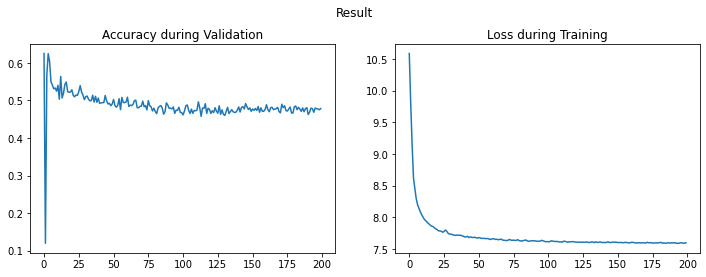

In [11]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

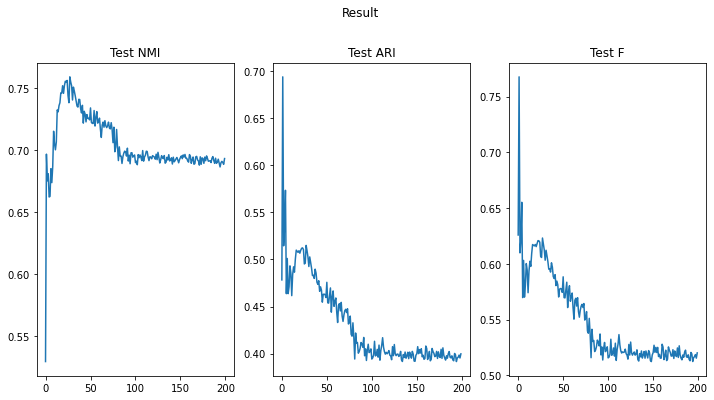

In [12]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].plot(nmis)
ax[0].set_title('Test NMI')
ax[1].plot(aris)
ax[1].set_title('Test ARI')
ax[2].plot(fs)
ax[2].set_title('Test F')


plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

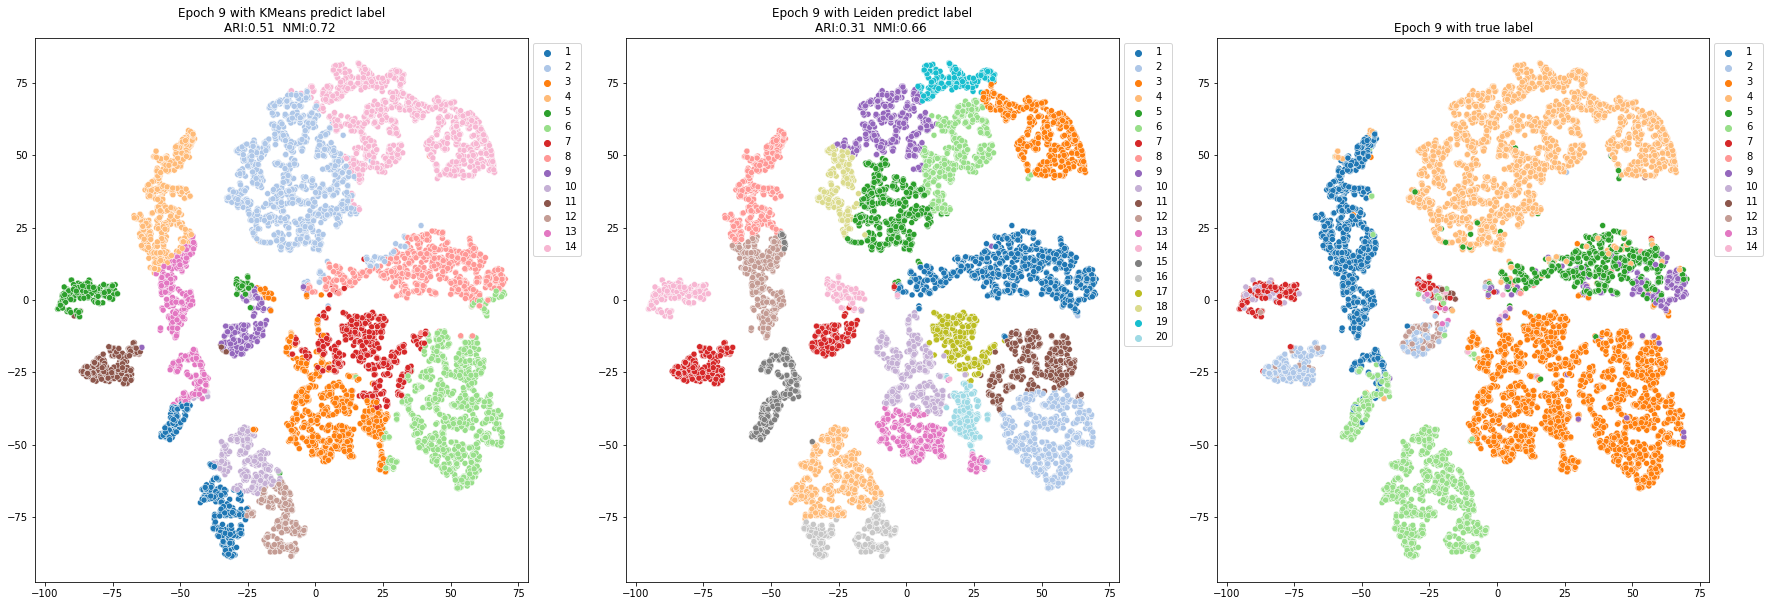

In [13]:
from evaluation import evaluation_tools
from sklearn.manifold import TSNE

mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim, args.classnum)
model = model.to('cuda')

checkpoint = torch.load('save\sc-static-bank\checkpoint_9.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=9)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

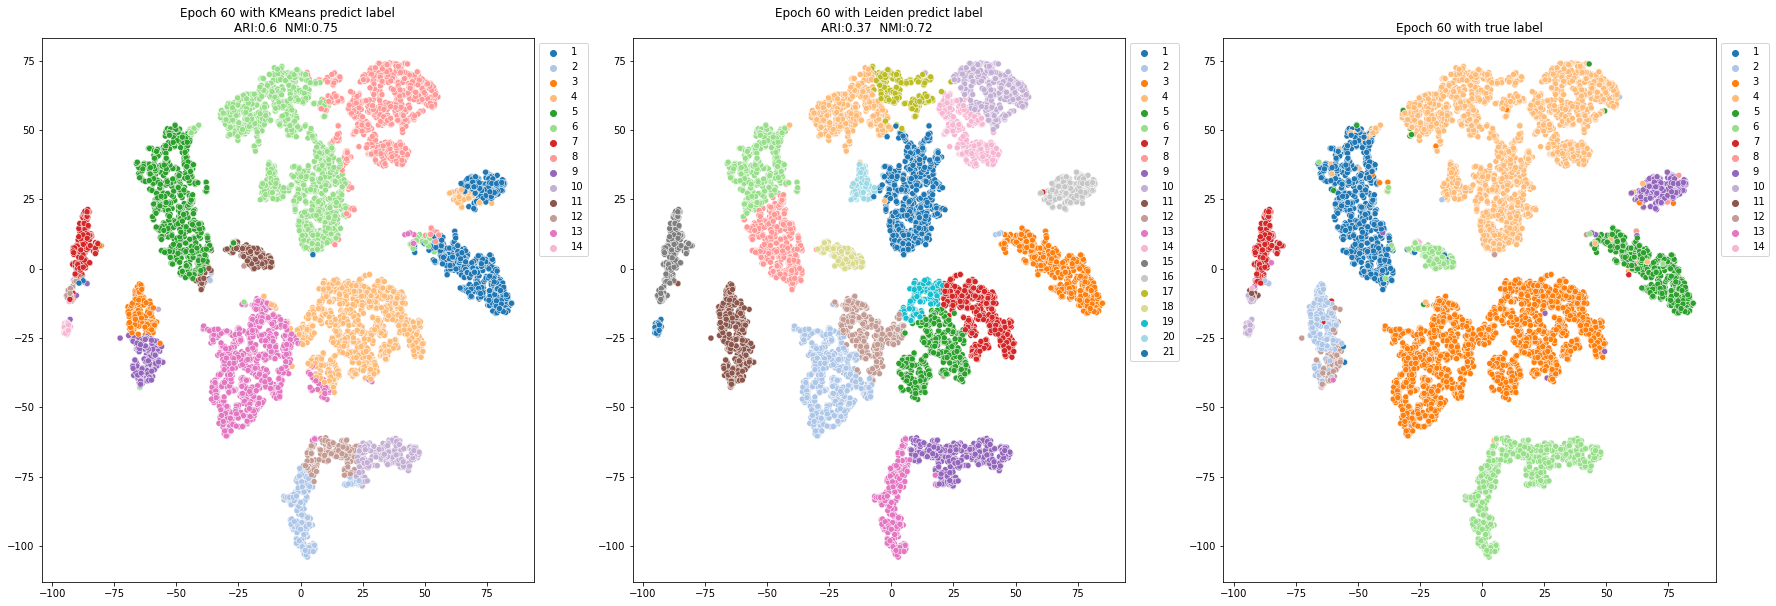

In [14]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_60.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=60)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

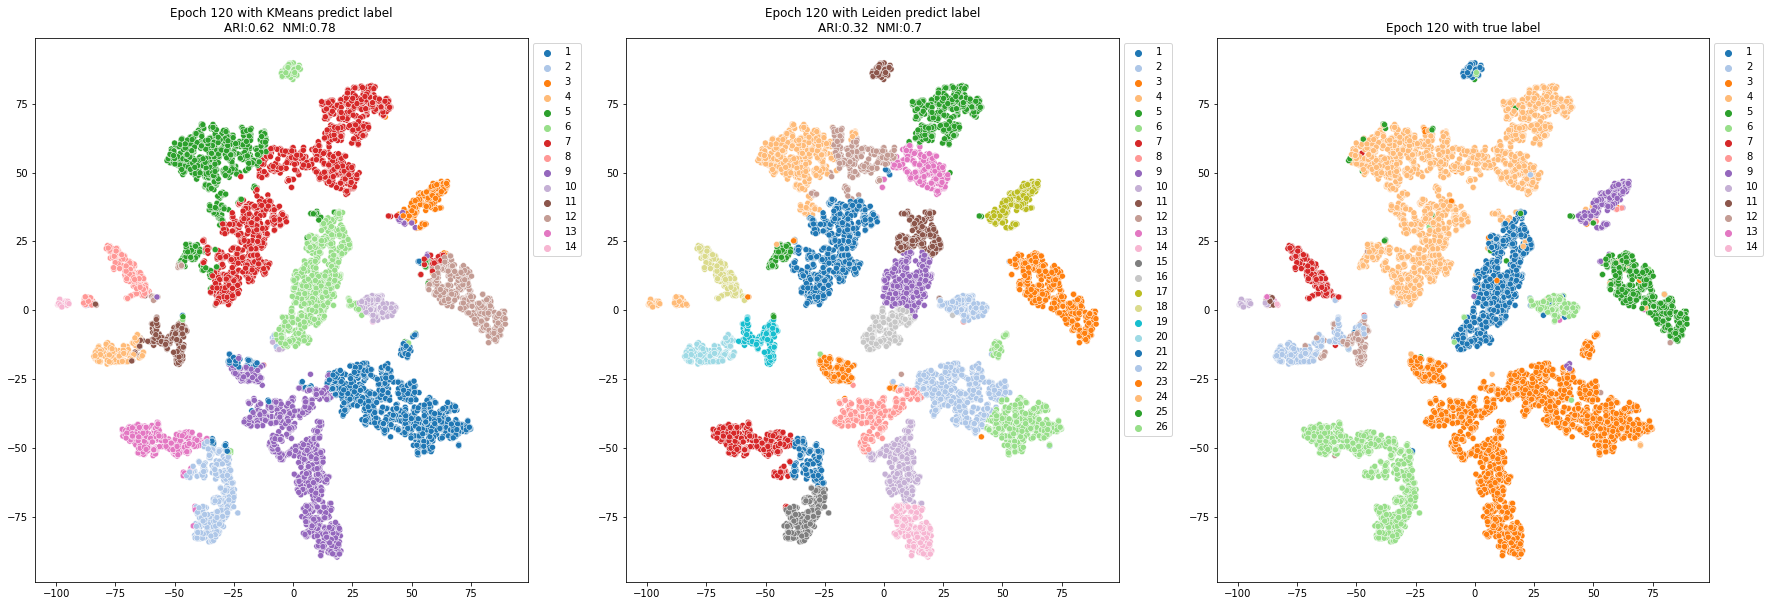

In [15]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_120.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=120)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

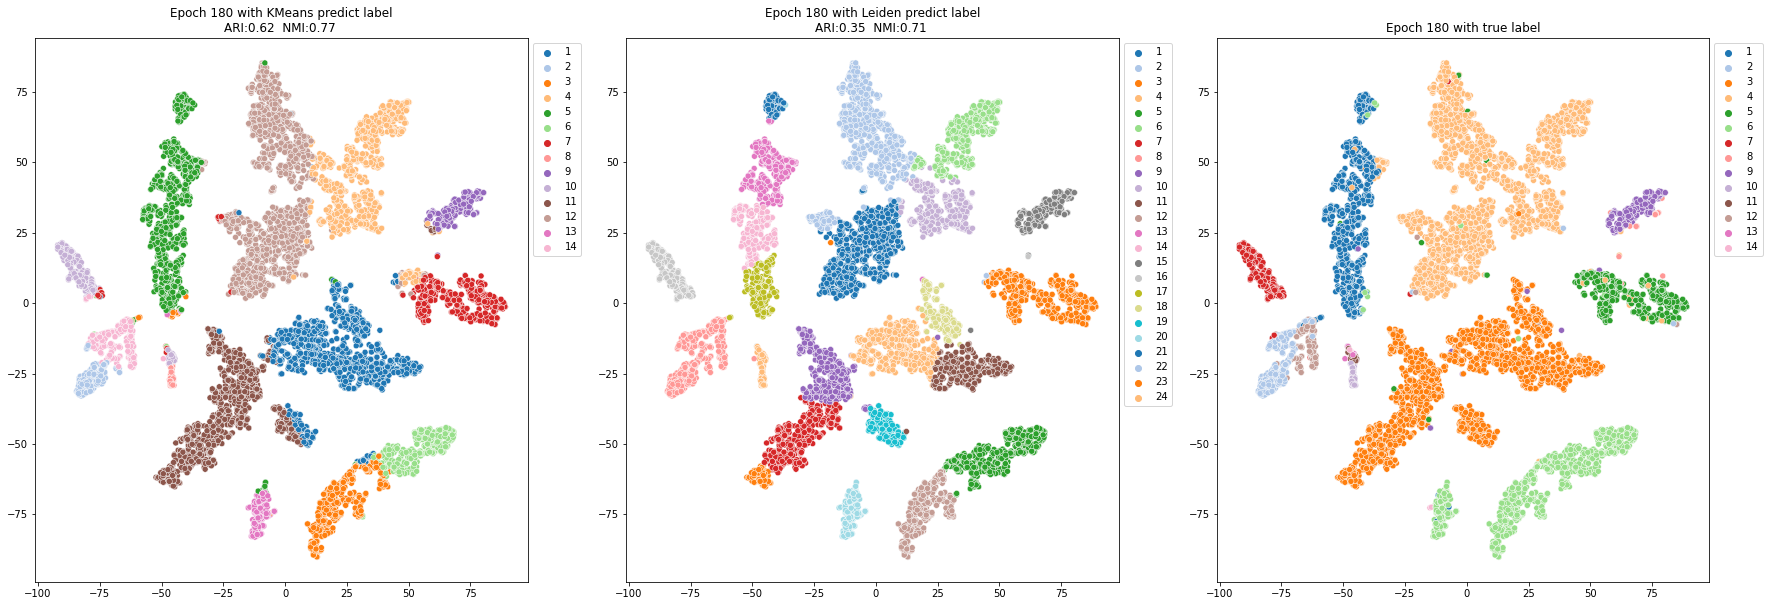

In [16]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_180.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

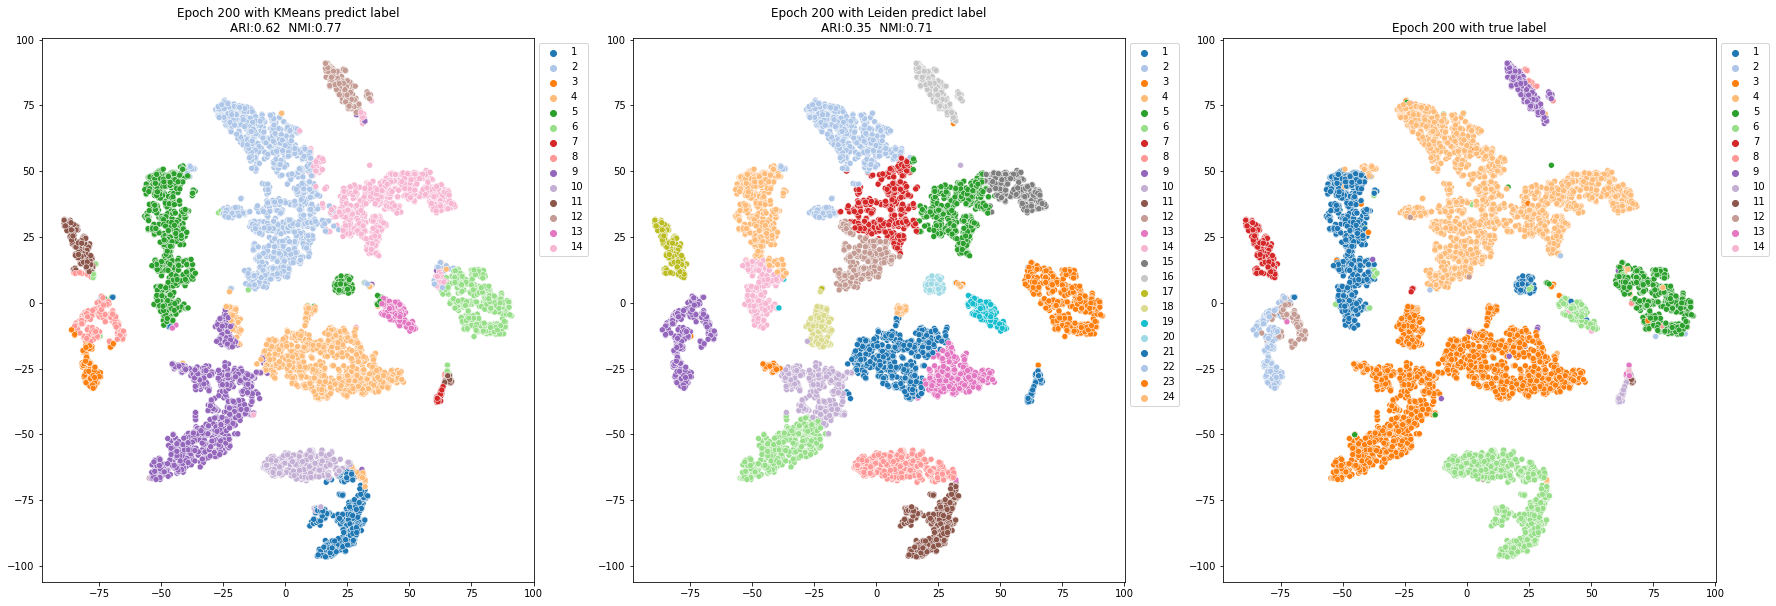

In [17]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_200.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=200)